<a href="https://colab.research.google.com/github/jamesmuiru/mlfccourse/blob/main/Healthcare_Infrastructure_Optimization_in_Central_Kenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Access

**Population Density data access**

In [75]:
import requests
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define URL and output path
url = "https://data.worldpop.org/GIS/Population_Density/Global_2000_2020_1km/2020/KEN/ken_pd_2020_1km.tif"
output_dir = "/content/drive/MyDrive/Miniproject/Population_density"
os.makedirs(output_dir, exist_ok=True)  # make folder if not exists
output_path = os.path.join(output_dir, "ken_pd_2020_1km.tif")

# Download file
r = requests.get(url, allow_redirects=True, stream=True)
with open(output_path, 'wb') as f:
    for chunk in r.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

print(f"✅ File downloaded and saved to: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File downloaded and saved to: /content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif


In [76]:
raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities="/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads="/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household="/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv" ## V
distance_health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads.tif"


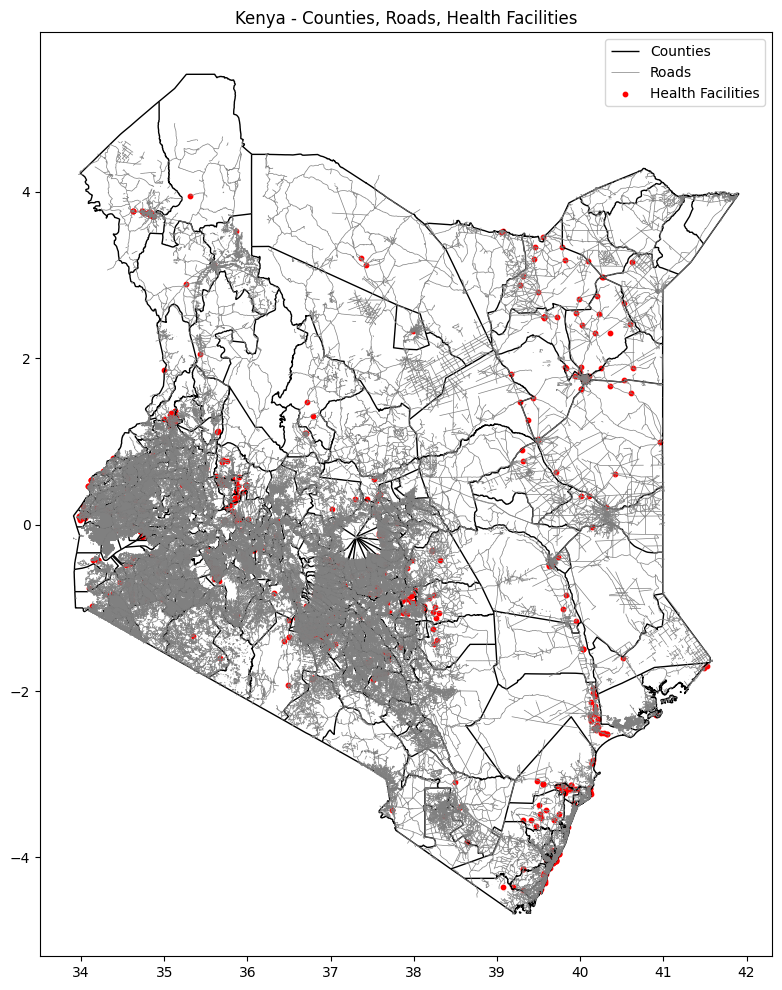

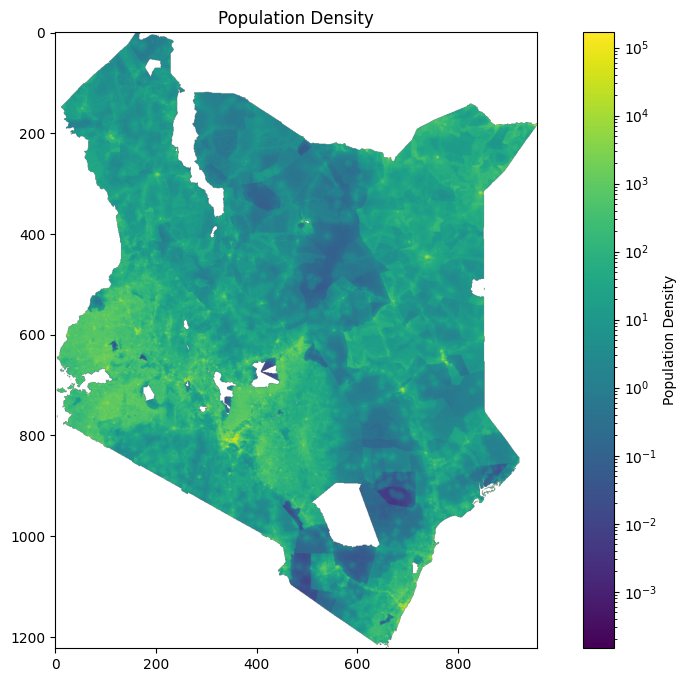

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LogNorm
import pandas as pd # Import pandas

# Read vector datasets
gdf_counties = gpd.read_file(counties_boundaries)
gdf_health = gpd.read_file(point_health_facilities)
gdf_roads = gpd.read_file(lines_roads)
# Read CSV file using pandas
df_households = pd.read_csv(average_household)


# Plot vector datasets
fig, ax = plt.subplots(figsize=(12, 12))
gdf_counties.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="Counties")
gdf_roads.plot(ax=ax, color="gray", linewidth=0.5, label="Roads")
gdf_health.plot(ax=ax, color="red", markersize=10, label="Health Facilities")
# Cannot plot df_households directly as it is not a GeoDataFrame
# gdf_households.plot(ax=ax, color="blue", markersize=5, label="Households")

# Add legend
plt.legend()
plt.title("Kenya - Counties, Roads, Health Facilities")
plt.show()

# Plot raster population density
src = rasterio.open(raster_populationdensity)
plt.figure(figsize=(12, 8))
plt.imshow(src.read(1), cmap="viridis",norm=LogNorm())
plt.colorbar(label="Population Density")
plt.title("Population Density")
plt.show()

In [78]:
## get the datasets properties
print(gdf_counties.crs)
print(gdf_health.crs)
print(gdf_roads.crs)
print(df_households.head())


EPSG:4326
EPSG:4326
EPSG:4326
                                          Unnamed: 0 Unnamed: 1
0               Average Household Size by Sub-County        NaN
1  Source: 2019 Kenya Population and Housing Cens...        NaN
2  https://wwwknbsorke/?wpdmpro=2019-kenya-popula...        NaN
3          Household size, Sub-county, County, Kenya        NaN
4                                                NaN        NaN


In [79]:
df_households_columns=[x for x in df_households.columns]


### Assess

In [80]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
from scipy.ndimage import distance_transform_edt

# Paths


point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads = "/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"


# -----------------------------
# 1. Load raster (population density) as reference grid
# -----------------------------
with rasterio.open(raster_populationdensity) as src:
    profile = src.profile
    transform = src.transform
    shape = src.shape
    crs = src.crs

# -----------------------------
# 2. Load vector data (health facilities and roads)
# -----------------------------
gdf_health = gpd.read_file(point_health_facilities).to_crs(crs)
gdf_roads = gpd.read_file(lines_roads).to_crs(crs)

# -----------------------------
# 3. Rasterize the facilities and roads
# -----------------------------
# Rasterize health facilities
health_raster = rasterize(
    [(geom, 1) for geom in gdf_health.geometry],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# Rasterize roads
roads_raster = rasterize(
    [(geom, 1) for geom in gdf_roads.geometry],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# -----------------------------
# 4. Compute Euclidean distance (in raster grid cells)
# -----------------------------
# Distance from health facilities
dist_health = distance_transform_edt(health_raster == 0) * profile["transform"][0]

# Distance from roads
dist_roads = distance_transform_edt(roads_raster == 0) * profile["transform"][0]

# -----------------------------
# 5. Combine results (example: minimum distance to either road or health facility)
# -----------------------------
dist_combined = np.minimum(dist_health, dist_roads)

# -----------------------------
# 6. Save output raster
# -----------------------------
output_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(dist_combined.astype(rasterio.float32), 1)

print("✅ Euclidean distance raster saved at:", output_path)


✅ Euclidean distance raster saved at: /content/drive/MyDrive/Miniproject/distance_health_roads.tif


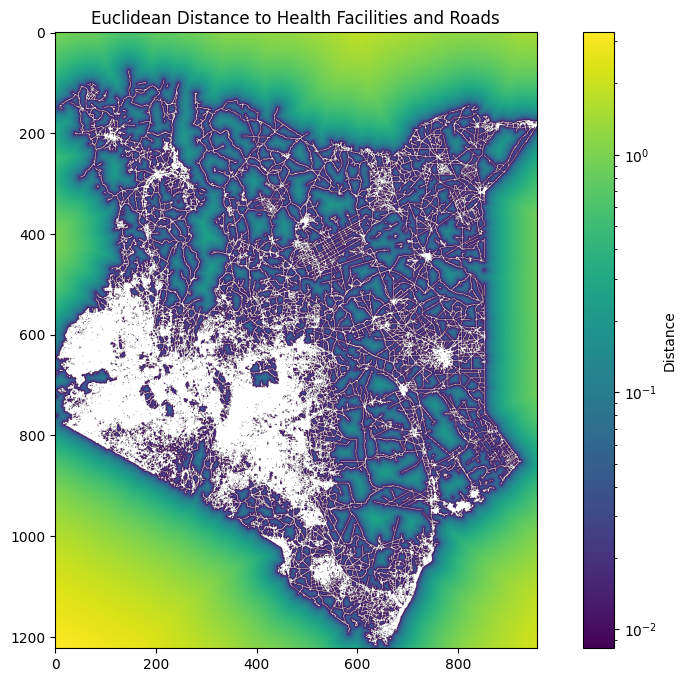

In [81]:
## plot this dataset /content/drive/MyDrive/Miniproject/distance_health_roads.tif
import matplotlib.pyplot as plt
import rasterio
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
with rasterio.open(distance_raster_path) as src:
    profile = src.profile
    transform = src.transform
    shape = src.shape
    crs = src.crs
    distance_data = src.read(1)
    plt.figure(figsize=(12, 8))
    plt.imshow(distance_data, cmap="viridis",norm=LogNorm())
    plt.colorbar(label="Distance")
    plt.title("Euclidean Distance to Health Facilities and Roads")
    plt.show()

# clip based on the shapefile
shapefile="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
gdf_counties = gpd.read_file(shapefile)

## Get Zonal statistics for each area

In [82]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
constituency_boundaries = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"

# -----------------------------
# 1. Load constituency boundaries
# -----------------------------
gdf_constituencies = gpd.read_file(constituency_boundaries)

# -----------------------------
# 2. Make sure CRS matches raster
# -----------------------------
with rasterio.open(distance_raster_path) as src:
    gdf_constituencies = gdf_constituencies.to_crs(src.crs)

# -----------------------------
# 3. Calculate mean distance per constituency
# -----------------------------
stats = zonal_stats(
    vectors=gdf_constituencies,
    raster=distance_raster_path,
    stats=["mean"],
    geojson_out=True
)

# -----------------------------
# 4. Convert results back to GeoDataFrame
# -----------------------------
gdf_with_mean = gpd.GeoDataFrame.from_features(stats)

# -----------------------------
# 5. Save as new shapefile/GeoPackage
# -----------------------------
output_path = "/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"
gdf_with_mean.to_file(output_path)

print("✅ Constituencies with mean distance saved at:", output_path)
print(gdf_with_mean.head())


✅ Constituencies with mean distance saved at: /content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp
                                            geometry  Shape_Leng  admLevel  \
0  LINESTRING (39.22308 -4.66901, 39.22034 -4.671...    0.014668        99   
1  LINESTRING (39.21667 -4.66071, 39.21472 -4.662...    0.007563        99   
2  LINESTRING (39.22779 -4.6603, 39.22745 -4.6613...    0.019891        99   
3  LINESTRING (39.28229 -4.66699, 39.27832 -4.668...    0.048525        99   
4  LINESTRING (39.36432 -4.65521, 39.36768 -4.655...    0.127815        99   

        date    validON validTo      mean  
0 2018-06-07 2019-10-31    None  0.008333  
1 2018-06-07 2019-10-31    None  0.000000  
2 2018-06-07 2019-10-31    None  0.004167  
3 2018-06-07 2019-10-31    None  0.056510  
4 2018-06-07 2019-10-31    None  0.006402  


In [83]:
constituencies_mean_distance="/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"
constituencies_mean_distance=gpd.read_file(constituencies_mean_distance)
constituencies_mean_distance.head(10)


Shape_Leng  admLevel       date    validON validTo      mean  \
0    0.014668        99 2018-06-07 2019-10-31    None  0.008333   
1    0.007563        99 2018-06-07 2019-10-31    None  0.000000   
2    0.019891        99 2018-06-07 2019-10-31    None  0.004167   
3    0.048525        99 2018-06-07 2019-10-31    None  0.056510   
4    0.127815        99 2018-06-07 2019-10-31    None  0.006402   
5    0.023417        99 2018-06-07 2019-10-31    None  0.002778   
6    0.008071        99 2018-06-07 2019-10-31    None  0.018634   
7    0.007528        99 2018-06-07 2019-10-31    None  0.026352   
8    0.018769        99 2018-06-07 2019-10-31    None  0.025676   
9    0.019899        99 2018-06-07 2019-10-31    None  0.010059   

                                            geometry  
0  LINESTRING (39.22308 -4.66901, 39.22034 -4.671...  
1  LINESTRING (39.21667 -4.66071, 39.21472 -4.662...  
2  LINESTRING (39.22779 -4.6603, 39.22745 -4.6613...  
3  LINESTRING (39.28229 -4.66699, 39.27832 -4.668...  
4  LINESTRING (39.36432 -4.65521, 39.36768 -4.655...  
5  LINESTRING (39.21667 -4.66071, 39.21667 -4.660...  
6  LINESTRING (39.23413 -4.64728, 39.2323 -4.6500...  
7  LINESTRING (39.24487 -4.6192, 39.24432 -4.6215...  
8  LINESTRING (39.29187 -4.59607, 39.29132 -4.599...  
9  LINESTRING (39.43011 -4.58191, 39.42767 -4.583...

   Shape_Leng  admLevel       date    validON validTo      mean  \
0    0.014668        99 2018-06-07 2019-10-31    None  0.008333   
1    0.007563        99 2018-06-07 2019-10-31    None  0.000000   
2    0.019891        99 2018-06-07 2019-10-31    None  0.004167   
3    0.048525        99 2018-06-07 2019-10-31    None  0.056510   
4    0.127815        99 2018-06-07 2019-10-31    None  0.006402   
5    0.023417        99 2018-06-07 2019-10-31    None  0.002778   
6    0.008071        99 2018-06-07 2019-10-31    None  0.018634   
7    0.007528        99 2018-06-07 2019-10-31    None  0.026352   
8    0.018769        99 2018-06-07 2019-10-31    None  0.025676   
9    0.019899        99 2018-06-07 2019-10-31    None  0.010059   

                                            geometry  
0  LINESTRING (39.22308 -4.66901, 39.22034 -4.671...  
1  LINESTRING (39.21667 -4.66071, 39.21472 -4.662...  
2  LINESTRING (39.22779 -4.6603, 39.22745 -4.6613...  
3  LINESTRING (39.28229 -4.66699, 39.27832

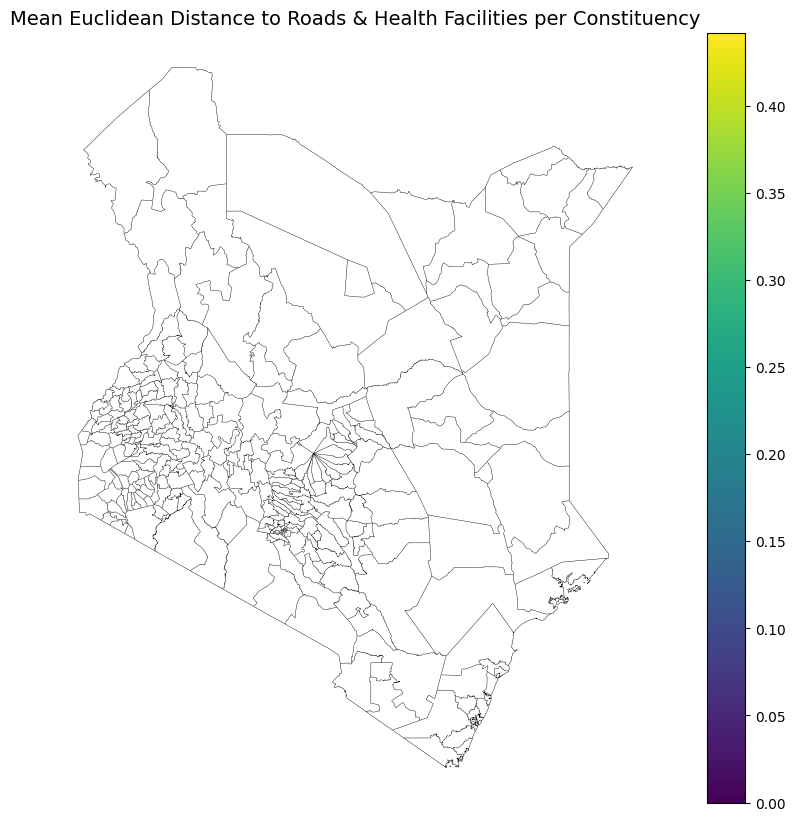

In [84]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to your shapefile with mean distances
constituencies_mean_distance = "/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"

# Read the shapefile
gdf = gpd.read_file(constituencies_mean_distance)

# Check first 10 rows
print(gdf.head(10))

# -----------------------------
# Plot choropleth by mean distance
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf.plot(
    column="mean",       # column with mean distance
    cmap="viridis",      # color map
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

ax.set_title("Mean Euclidean Distance to Roads & Health Facilities per Constituency", fontsize=14)
ax.axis("off")

plt.show()


In [85]:
print(gdf["mean"].describe())
print(gdf[["mean"]].head(20))


count    891.000000
mean       0.007330
std        0.020903
min        0.000000
25%        0.000000
50%        0.000889
75%        0.007111
max        0.441931
Name: mean, dtype: float64
        mean
0   0.008333
1   0.000000
2   0.004167
3   0.056510
4   0.006402
5   0.002778
6   0.018634
7   0.026352
8   0.025676
9   0.010059
10  0.010510
11  0.016124
12  0.012262
13  0.011785
14  0.011785
15  0.009043
16  0.008333
17  0.000260
18  0.009790
19  0.000672


## Clip raster distance

✅ Raster clipped and saved at: /content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif


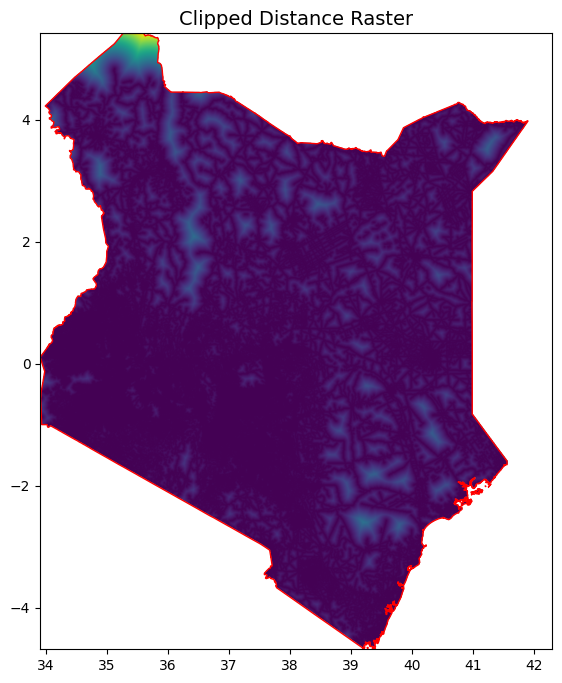

In [86]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paths
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
output_clipped = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"

# Read shapefile
gdf_country = gpd.read_file(country_dataset)

# Open raster
with rasterio.open(distance_raster_path) as src:
    # Reproject shapefile to raster CRS
    gdf_country = gdf_country.to_crs(src.crs)

    # Extract geometry
    geoms = gdf_country.geometry.values

    # Clip raster with mask
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# Update metadata for clipped raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save clipped raster
with rasterio.open(output_clipped, "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Raster clipped and saved at:", output_clipped)

# -------------------------------
# Plot clipped raster
# -------------------------------
with rasterio.open(output_clipped) as clipped:
    fig, ax = plt.subplots(figsize=(10, 8))
    rasterio.plot.show(clipped, ax=ax, cmap="viridis")
    gdf_country.boundary.plot(ax=ax, edgecolor="red", linewidth=1)
    plt.title("Clipped Distance Raster", fontsize=14)
    plt.show()


## Clip population

✅ Raster clipped and saved at: /content/drive/MyDrive/Miniproject/masked_population_density.tif


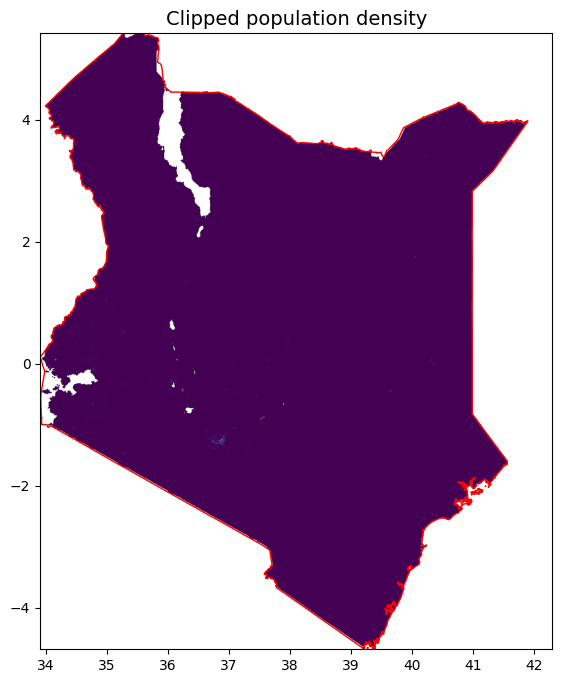

In [87]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paths
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"

raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
output_clipped = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"

# Read shapefile
gdf_country = gpd.read_file(country_dataset)

# Open raster
with rasterio.open(raster_populationdensity) as src:
    # Reproject shapefile to raster CRS
    gdf_country = gdf_country.to_crs(src.crs)

    # Extract geometry
    geoms = gdf_country.geometry.values

    # Clip raster with mask
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# Update metadata for clipped raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save clipped raster
with rasterio.open(output_clipped, "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Raster clipped and saved at:", output_clipped)

# -------------------------------
# Plot clipped raster
# -------------------------------
with rasterio.open(output_clipped) as clipped:
    fig, ax = plt.subplots(figsize=(10, 8))
    rasterio.plot.show(clipped, ax=ax, cmap="viridis")
    gdf_country.boundary.plot(ax=ax, edgecolor="red", linewidth=1)
    plt.title("Clipped population density", fontsize=14)
    plt.show()


In [88]:
distance_health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
country_dataset="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities="/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads="/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household="/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv"


In [89]:
import geopandas as gpd
import pandas as pd
import rasterio

# Paths
distance_health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
raster_populationdensity = "/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads = "/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household = "/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv"

# --- Raster files (inspect metadata instead of columns) ---
def inspect_raster(path):
    with rasterio.open(path) as src:
        print(f"\n📂 Raster: {path}")
        print("Bands:", src.count)
        print("Width x Height:", src.width, "x", src.height)
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("First 3 values from band 1:", src.read(1).ravel()[:3])

inspect_raster(distance_health_roads)
inspect_raster(raster_populationdensity)

# --- Vector shapefiles ---
def inspect_vector(path):
    gdf = gpd.read_file(path)
    print(f"\n📂 Vector: {path}")
    print("Columns:", list(gdf.columns))
    print("First 3 rows:\n", gdf.head(7))
    return gdf

gdf_country = inspect_vector(country_dataset)
gdf_counties = inspect_vector(counties_boundaries)
gdf_health = inspect_vector(point_health_facilities)
gdf_roads = inspect_vector(lines_roads)

# --- CSV ---
df_households = pd.read_csv(average_household)
print(f"\n📂 CSV: {average_household}")
print("Columns:", list(df_households.columns))
print("First 3 rows:\n", df_households.head(3))



📂 Raster: /content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif
Bands: 1
Width x Height: 957 x 1212
CRS: EPSG:4326
Bounds: BoundingBox(left=33.9070832014676, bottom=-4.683749773636145, right=41.8820831695676, top=5.416250185963855)
First 3 values from band 1: [-99999. -99999. -99999.]

📂 Raster: /content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif
Bands: 1
Width x Height: 957 x 1223
CRS: EPSG:4326
Bounds: BoundingBox(left=33.9070832014676, bottom=-4.725416440136145, right=41.8820831695676, top=5.466250185763855)
First 3 values from band 1: [-99999. -99999. -99999.]

📂 Vector: /content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp
Columns: ['Shape_Leng', 'Shape_Area', 'ADM0_EN', 'ADM0_PCODE', 'ADM0_REF', 'ADM0ALT1EN', 'ADM0ALT2EN', 'date', 'validOn', 'validTo', 'geometry']
First 3 rows:
    Shape_Leng  Shape_Area ADM0_EN ADM0_PCODE ADM0_REF ADM0ALT1EN ADM0ALT2EN  \
0   44.052413   48.098756   Kenya         KE     None       

In [90]:
population_density_file="/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
costituencies="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"



In [91]:
constituencies=gpd.read_file(costituencies)
constituencies.head()

Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0    1.746986    0.040829      Ainabkoi   KE027144     None       None   
1    0.917307    0.019957       Ainamoi   KE035190     None       None   
2    1.402637    0.038000         Aldai   KE029152     None       None   
3    1.081354    0.049357  Alego Usonga   KE041234     None       None   
4    0.743915    0.021365        Awendo   KE044254     None       None   

  ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
0       None  Uasin Gishu      KE027   Kenya         KE 2017-11-03 2019-10-31   
1       None      Kericho      KE035   Kenya         KE 2017-11-03 2019-10-31   
2       None        Nandi      KE029   Kenya         KE 2017-11-03 2019-10-31   
3       None        Siaya      KE041   Kenya         KE 2017-11-03 2019-10-31   
4       None       Migori      KE044   Kenya         KE 2017-11-03 2019-10-31   

  ValidTo                                           geometry  
0     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...  
1     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...  
2     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...  
3     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...  
4     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...

In [92]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
population_density_file = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"

# Load constituencies
gdf_const = gpd.read_file(constituencies)

# --- Mean Population Density ---
stats_pop = zonal_stats(
    gdf_const,
    population_density_file,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# --- Mean Distance to Health/Roads ---
stats_health = zonal_stats(
    gdf_const,
    health_roads,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# Add results as new columns
gdf_const["mean_pop_density"] = [s["mean"] for s in stats_pop]
gdf_const["mean_distance_health_roads"] = [s["mean"] for s in stats_health]

# Save updated shapefile
gdf_const.to_file(output_shapefile)

print("✅ Zonal statistics completed and saved to:", output_shapefile)
print(gdf_const[["mean_pop_density", "mean_distance_health_roads"]].head())


✅ Zonal statistics completed and saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
   mean_pop_density  mean_distance_health_roads
0        309.248096                    0.000742
1        851.060467                    0.000143
2        492.913453                    0.002069
3        393.381925                    0.001153
4        533.473127                    0.000391


In [93]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
population_density_file = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"

# Load constituencies
gdf_const = gpd.read_file(constituencies)

# --- Mean Population Density ---
stats_pop = zonal_stats(
    gdf_const,
    population_density_file,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# --- Mean Distance to Health/Roads (in degrees) ---
stats_health = zonal_stats(
    gdf_const,
    health_roads,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# Add results as new columns
gdf_const["mean_pop_density"] = [s["mean"] for s in stats_pop]
gdf_const["mean_distance_deg"] = [s["mean"] for s in stats_health]

# Convert degrees → meters (approx: 1° ≈ 111.32 km)
deg_to_m = 111320
gdf_const["mean_distance_m"] = gdf_const["mean_distance_deg"] * deg_to_m

# Save updated shapefile
gdf_const.to_file(output_shapefile)

print("✅ Zonal statistics completed and saved to:", output_shapefile)
print(gdf_const[["mean_pop_density", "mean_distance_deg", "mean_distance_m"]].head())


✅ Zonal statistics completed and saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
   mean_pop_density  mean_distance_deg  mean_distance_m
0        309.248096           0.000742        82.653135
1        851.060467           0.000143        15.884702
2        492.913453           0.002069       230.285182
3        393.381925           0.001153       128.390392
4        533.473127           0.000391        43.555650


Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'ValidTo', 'mean_pop_d', 'mean_dista',
       'mean_dis_1', 'geometry'],
      dtype='object')


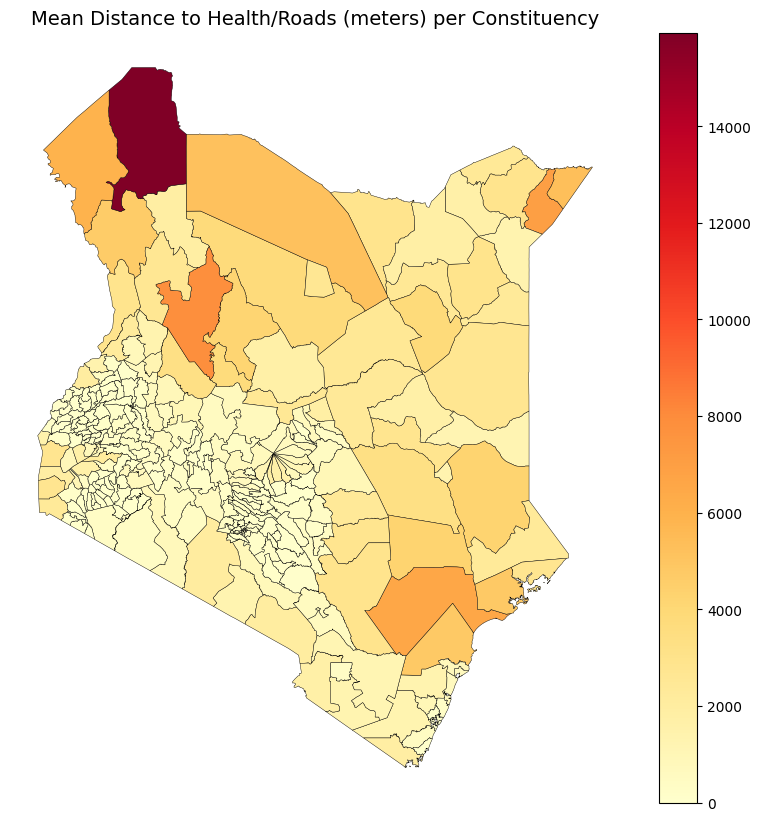

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the updated shapefile with stats
gdf_const = gpd.read_file(output_shapefile)

# Print column names to identify the correct column for plotting
print(gdf_const.columns)

# Plot choropleth based on mean distance (in meters)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_const.plot(
    column="mean_dis_1",      # the column to base color on
    cmap="YlOrRd",                 # color map (Yellow → Red)
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# Add title
ax.set_title("Mean Distance to Health/Roads (meters) per Constituency", fontsize=14)

# Remove axis
ax.set_axis_off()

plt.show()

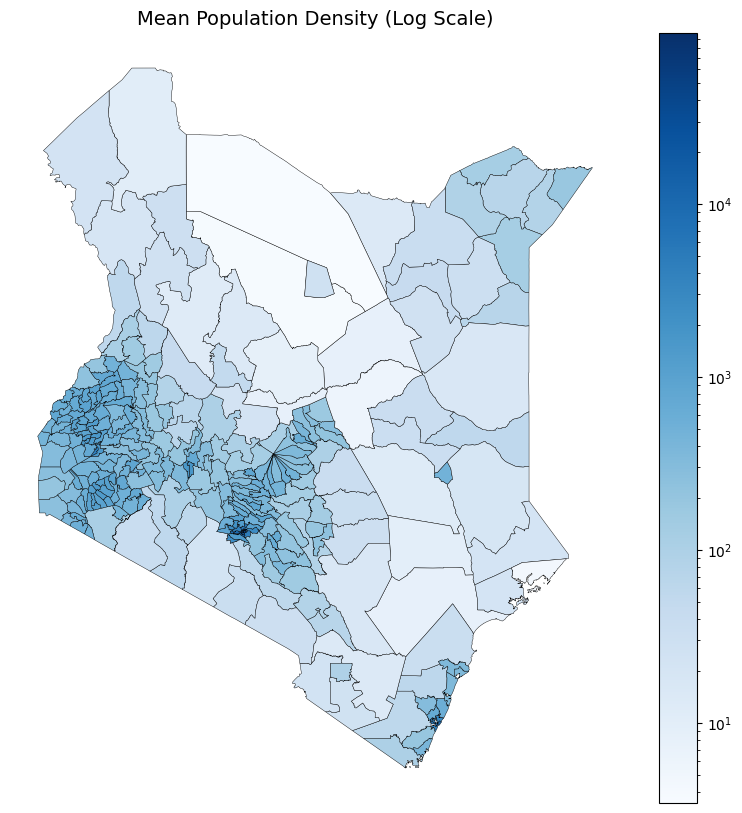

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Load shapefile
gdf_const = gpd.read_file(output_shapefile)

# Plot with log scale
fig, ax = plt.subplots(figsize=(10, 10))
gdf_const.plot(
    column="mean_pop_d",
    cmap="Blues",
    norm=colors.LogNorm(vmin=gdf_const["mean_pop_d"].min()+1,
                        vmax=gdf_const["mean_pop_d"].max()),
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

ax.set_title("Mean Population Density (Log Scale)", fontsize=14)
ax.set_axis_off()
plt.show()


🔧 FIXING HEALTHCARE ANALYSIS - Column Issues Resolved
🏜️ IDENTIFYING HEALTHCARE GAPS (FIXED VERSION)...
   📊 Loaded 290 constituencies
   📋 Available columns: ['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn', 'ValidTo', 'mean_pop_d', 'mean_dista', 'mean_dis_1', 'geometry']
   ✅ Using distance column: mean_dis_1
   ✅ Using population column: mean_pop_d
   📏 Distance threshold: 1074
   👥 Population threshold: 381.7
   ✅ Healthcare Gaps Identified:
      • Critical Need Areas: 10 (3.4%)
      • Medium Need Areas: 198 (68.3%)
      • Good Access Areas: 82 (28.3%)
      • Average Healthcare Need Score: 0.040
   💾 Analysis saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_analysis.gpkg
   💾 Updated shapefile: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
🗺️ CREATING COMPREHENSIVE MAPS (FIXED VERSION)...
   📋 Available columns: ['S

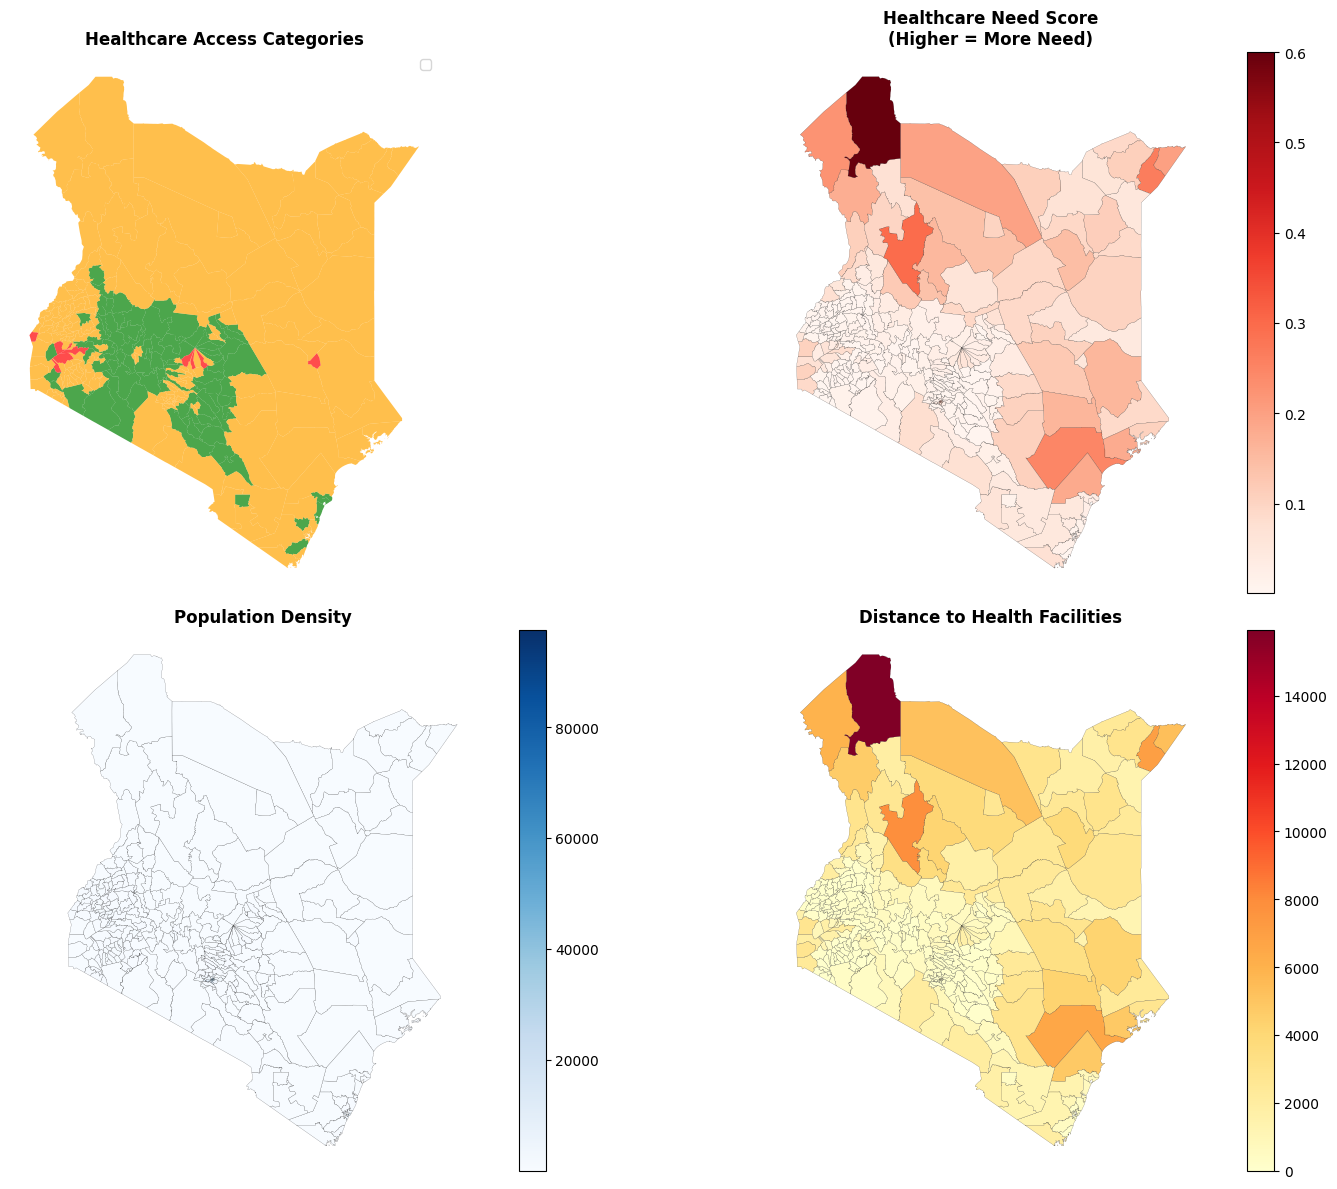

   ✅ Comprehensive maps created and saved: /content/drive/MyDrive/Miniproject/healthcare_analysis_comprehensive_fixed.png
🤖 DEVELOPING SIMPLIFIED ML MODEL...
   ✅ Using features: mean_dis_1, mean_pop_d
   ✅ Model Performance:
      • R² Score: 0.769
      • MSE: 0.001
🎯 CREATING TOP 5 FACILITY RECOMMENDATIONS...
   ✅ TOP FACILITY RECOMMENDATIONS:
      1. Turkana North, Turkana
         Priority Score: 0.600

      2. Mathare, Nairobi
         Priority Score: 0.400

      3. Turkana East, Turkana
         Priority Score: 0.297

      4. Lafey, Mandera
         Priority Score: 0.264

      5. Garsen, Tana River
         Priority Score: 0.248

   💾 Recommendations saved to CSV file

🎉 KENYA HEALTHCARE PROJECT COMPLETED (FIXED VERSION)!

✅ DELIVERABLES CREATED:
   📊 1. Healthcare access gap analysis
   🗺️ 2. Comprehensive visualization maps
   🤖 3. Machine learning facility optimization model
   📄 4. Top 5 facility location recommendations
   💾 5. Analysis results in multiple formats

📁 O

In [96]:
# Fixed Healthcare Analysis Code - Handling Shapefile Column Issues
# This fixes the KeyError issue with column names

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
import folium
import rasterio
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Your existing file paths
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"
point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"

print("🔧 FIXING HEALTHCARE ANALYSIS - Column Issues Resolved")
print("=" * 60)

# =====================================================
# TASK 1: FIXED HEALTHCARE GAP IDENTIFICATION
# =====================================================

def identify_healthcare_gaps_fixed():
    """FIXED: Identify constituencies with poor healthcare access"""
    print("🏜️ IDENTIFYING HEALTHCARE GAPS (FIXED VERSION)...")

    # Load your processed data
    gdf_const = gpd.read_file(output_shapefile)

    print(f"   📊 Loaded {len(gdf_const)} constituencies")
    print(f"   📋 Available columns: {list(gdf_const.columns)}")

    # Check what columns we actually have and handle different naming
    distance_col = None
    pop_col = None

    # Find distance column (could be mean_dis_1, mean_distance_m, etc.)
    possible_distance_cols = ['mean_dis_1', 'mean_distance_m', 'mean_distance_deg', 'mean_dist']
    for col in possible_distance_cols:
        if col in gdf_const.columns:
            distance_col = col
            break

    # Find population column
    possible_pop_cols = ['mean_pop_d', 'mean_pop_density', 'population', 'pop_density']
    for col in possible_pop_cols:
        if col in gdf_const.columns:
            pop_col = col
            break

    if distance_col is None or pop_col is None:
        print(f"   ❌ Error: Cannot find required columns")
        print(f"      Distance column found: {distance_col}")
        print(f"      Population column found: {pop_col}")
        return gdf_const

    print(f"   ✅ Using distance column: {distance_col}")
    print(f"   ✅ Using population column: {pop_col}")

    # Handle missing values
    gdf_const[distance_col] = gdf_const[distance_col].fillna(gdf_const[distance_col].median())
    gdf_const[pop_col] = gdf_const[pop_col].fillna(gdf_const[pop_col].median())

    # Define healthcare desert thresholds
    distance_threshold = gdf_const[distance_col].quantile(0.75)  # Top 25% of distances
    population_threshold = gdf_const[pop_col].median()  # Use median as threshold

    print(f"   📏 Distance threshold: {distance_threshold:.0f}")
    print(f"   👥 Population threshold: {population_threshold:.1f}")

    # Create healthcare access categories using simplified column names (for shapefile compatibility)
    gdf_const['hlth_acc'] = 'Good'  # Shortened column name

    # High need areas: Far from facilities AND have population
    high_need_mask = (gdf_const[distance_col] > distance_threshold) & \
                     (gdf_const[pop_col] > population_threshold)
    gdf_const.loc[high_need_mask, 'hlth_acc'] = 'Critical'

    # Medium need: Either far OR high population but not both
    medium_need_mask = ((gdf_const[distance_col] > distance_threshold) & \
                       (gdf_const[pop_col] <= population_threshold)) | \
                      ((gdf_const[distance_col] <= distance_threshold) & \
                       (gdf_const[pop_col] > population_threshold))
    gdf_const.loc[medium_need_mask, 'hlth_acc'] = 'Medium'

    # Calculate healthcare need score (higher = more need)
    # Normalize both metrics to 0-1 scale
    max_dist = gdf_const[distance_col].max()
    max_pop = gdf_const[pop_col].max()
    min_dist = gdf_const[distance_col].min()
    min_pop = gdf_const[pop_col].min()

    # Avoid division by zero
    if max_dist != min_dist:
        gdf_const['norm_dist'] = (gdf_const[distance_col] - min_dist) / (max_dist - min_dist)
    else:
        gdf_const['norm_dist'] = 0.5

    if max_pop != min_pop:
        gdf_const['norm_pop'] = (gdf_const[pop_col] - min_pop) / (max_pop - min_pop)
    else:
        gdf_const['norm_pop'] = 0.5

    # Combined healthcare need score (distance contributes 60%, population 40%)
    gdf_const['need_score'] = (gdf_const['norm_dist'] * 0.6) + \
                             (gdf_const['norm_pop'] * 0.4)

    # Summary statistics
    critical_count = len(gdf_const[gdf_const['hlth_acc'] == 'Critical'])
    medium_count = len(gdf_const[gdf_const['hlth_acc'] == 'Medium'])
    good_count = len(gdf_const[gdf_const['hlth_acc'] == 'Good'])
    total_count = len(gdf_const)

    print(f"   ✅ Healthcare Gaps Identified:")
    print(f"      • Critical Need Areas: {critical_count} ({critical_count/total_count*100:.1f}%)")
    print(f"      • Medium Need Areas: {medium_count} ({medium_count/total_count*100:.1f}%)")
    print(f"      • Good Access Areas: {good_count} ({good_count/total_count*100:.1f}%)")
    print(f"      • Average Healthcare Need Score: {gdf_const['need_score'].mean():.3f}")

    # Save updated file with shorter column names (shapefile compatible)
    try:
        # Use GeoPackage format for better column name support
        output_gpkg = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_analysis.gpkg"
        gdf_const.to_file(output_gpkg, driver='GPKG')
        print(f"   💾 Analysis saved to: {output_gpkg}")

        # Also save as shapefile with truncated columns
        gdf_const.to_file(output_shapefile)
        print(f"   💾 Updated shapefile: {output_shapefile}")

    except Exception as e:
        print(f"   ⚠️ Save warning: {e}")

    return gdf_const

# Run fixed gap identification
gdf_with_gaps = identify_healthcare_gaps_fixed()

# =====================================================
# TASK 2: FIXED COMPREHENSIVE VISUALIZATION
# =====================================================

def create_comprehensive_maps_fixed(gdf):
    """FIXED: Create comprehensive maps with proper column handling"""
    print("🗺️ CREATING COMPREHENSIVE MAPS (FIXED VERSION)...")

    # Check available columns
    print(f"   📋 Available columns: {list(gdf.columns)}")

    # Find the columns we need
    distance_col = None
    pop_col = None
    access_col = None
    need_col = None

    # Column detection
    for col in gdf.columns:
        if 'dis' in col.lower() and 'mean' in col.lower():
            distance_col = col
        elif 'pop' in col.lower() and 'mean' in col.lower():
            pop_col = col
        elif 'hlth' in col.lower() or 'access' in col.lower():
            access_col = col
        elif 'need' in col.lower() and 'score' in col.lower():
            need_col = col

    print(f"   🔍 Using columns: dist={distance_col}, pop={pop_col}, access={access_col}, need={need_col}")

    # Create multi-panel figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    try:
        # 1. Healthcare Access Categories (if available)
        ax1 = axes[0,0]
        if access_col and access_col in gdf.columns:
            # Get unique categories
            categories = gdf[access_col].unique()
            colors_dict = {'Good': 'green', 'Medium': 'orange', 'Critical': 'red'}

            # Plot by category
            for category in categories:
                subset = gdf[gdf[access_col] == category]
                color = colors_dict.get(category, 'gray')
                subset.plot(ax=ax1, color=color, alpha=0.7, label=category)

            ax1.legend()
            ax1.set_title('Healthcare Access Categories', fontsize=12, fontweight='bold')
        else:
            # Fallback: plot by distance
            gdf.plot(column=distance_col, cmap='Reds', ax=ax1, legend=True)
            ax1.set_title('Distance to Health Facilities', fontsize=12, fontweight='bold')
        ax1.axis('off')

        # 2. Healthcare Need Score (if available)
        ax2 = axes[0,1]
        if need_col and need_col in gdf.columns:
            gdf.plot(column=need_col, cmap='Reds', legend=True, ax=ax2,
                    edgecolor='black', linewidth=0.1)
            ax2.set_title('Healthcare Need Score\n(Higher = More Need)', fontsize=12, fontweight='bold')
        else:
            # Fallback: plot by distance
            gdf.plot(column=distance_col, cmap='Reds', legend=True, ax=ax2,
                    edgecolor='black', linewidth=0.1)
            ax2.set_title('Distance-Based Need', fontsize=12, fontweight='bold')
        ax2.axis('off')

        # 3. Population Density
        ax3 = axes[1,0]
        if pop_col and pop_col in gdf.columns:
            gdf.plot(column=pop_col, cmap='Blues', legend=True, ax=ax3,
                    edgecolor='black', linewidth=0.1)
            ax3.set_title('Population Density', fontsize=12, fontweight='bold')
        else:
            gdf.plot(ax=ax3, color='lightblue', edgecolor='black')
            ax3.set_title('Administrative Areas', fontsize=12, fontweight='bold')
        ax3.axis('off')

        # 4. Distance to Health Facilities
        ax4 = axes[1,1]
        if distance_col and distance_col in gdf.columns:
            gdf.plot(column=distance_col, cmap='YlOrRd', legend=True, ax=ax4,
                    edgecolor='black', linewidth=0.1)
            ax4.set_title('Distance to Health Facilities', fontsize=12, fontweight='bold')
        else:
            gdf.plot(ax=ax4, color='lightyellow', edgecolor='black')
            ax4.set_title('Administrative Boundaries', fontsize=12, fontweight='bold')
        ax4.axis('off')

        plt.tight_layout()

        # Save plot
        output_plot = '/content/drive/MyDrive/Miniproject/healthcare_analysis_comprehensive_fixed.png'
        plt.savefig(output_plot, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"   ✅ Comprehensive maps created and saved: {output_plot}")

    except Exception as e:
        print(f"   ⚠️ Visualization error: {e}")
        print("   🔄 Creating simplified visualization...")

        # Simple fallback visualization
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.7)
        ax.set_title('Kenya Administrative Areas - Healthcare Analysis', fontsize=14)
        ax.axis('off')
        plt.savefig('/content/drive/MyDrive/Miniproject/simple_map.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✅ Simplified map created")

# Create fixed maps
create_comprehensive_maps_fixed(gdf_with_gaps)

# =====================================================
# TASK 3: SIMPLIFIED MACHINE LEARNING MODEL
# =====================================================

def develop_simple_facility_model(gdf):
    """Simplified ML model with error handling"""
    print("🤖 DEVELOPING SIMPLIFIED ML MODEL...")

    # Find distance and population columns
    distance_col = None
    pop_col = None

    for col in gdf.columns:
        if 'dis' in col.lower() and ('mean' in col.lower() or 'avg' in col.lower()):
            distance_col = col
        elif 'pop' in col.lower() and ('mean' in col.lower() or 'avg' in col.lower()):
            pop_col = col

    if not distance_col or not pop_col:
        print(f"   ❌ Cannot find required columns for ML model")
        print(f"   📋 Available columns: {list(gdf.columns)}")
        return None, None

    print(f"   ✅ Using features: {distance_col}, {pop_col}")

    # Prepare features
    X = gdf[[distance_col, pop_col]].copy()
    X = X.fillna(X.median())  # Handle missing values

    # Create simple target: facility priority based on distance and population
    # Higher distance + higher population = higher priority
    X_norm = (X - X.min()) / (X.max() - X.min())  # Normalize to 0-1
    y = X_norm[distance_col] * 0.6 + X_norm[pop_col] * 0.4

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    r2_score = model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    print(f"   ✅ Model Performance:")
    print(f"      • R² Score: {r2_score:.3f}")
    print(f"      • MSE: {mse:.3f}")

    # Predict for all areas
    X_all_scaled = scaler.transform(X)
    facility_priority = model.predict(X_all_scaled)

    # Add to dataframe
    gdf['fac_prior'] = facility_priority  # Shortened name for shapefile

    return model, scaler

# Develop model
model_result = develop_simple_facility_model(gdf_with_gaps)

# =====================================================
# TASK 4: SIMPLE RECOMMENDATIONS
# =====================================================

def create_simple_recommendations(gdf, top_n=5):
    """Create simple facility recommendations"""
    print(f"🎯 CREATING TOP {top_n} FACILITY RECOMMENDATIONS...")

    # Find priority column
    priority_col = None
    for col in gdf.columns:
        if 'prior' in col.lower() or 'need' in col.lower():
            priority_col = col
            break

    if not priority_col:
        print("   ⚠️ No priority column found, using distance as proxy")
        # Use distance as priority (higher distance = higher priority)
        for col in gdf.columns:
            if 'dis' in col.lower():
                priority_col = col
                break

    if not priority_col:
        print("   ❌ Cannot create recommendations - no suitable column found")
        return pd.DataFrame()

    # Get top locations
    top_locations = gdf.nlargest(top_n, priority_col)

    # Create recommendations
    recommendations = []
    for idx, row in top_locations.iterrows():
        rec = {
            'rank': len(recommendations) + 1,
            'constituency': row.get('ADM2_EN', row.get('NAME_2', f'Area_{idx}')),
            'county': row.get('ADM1_EN', row.get('NAME_1', 'Unknown')),
            'priority_score': row[priority_col],
            'population_density': row.get('mean_pop_d', row.get(list(gdf.columns)[1], 0)),
            'distance_to_facility': row.get('mean_dis_1', row.get(list(gdf.columns)[2], 0))
        }
        recommendations.append(rec)

    recommendations_df = pd.DataFrame(recommendations)

    print("   ✅ TOP FACILITY RECOMMENDATIONS:")
    for _, rec in recommendations_df.iterrows():
        print(f"      {rec['rank']}. {rec['constituency']}, {rec['county']}")
        print(f"         Priority Score: {rec['priority_score']:.3f}")
        print()

    # Save recommendations
    recommendations_df.to_csv('/content/drive/MyDrive/Miniproject/facility_recommendations_fixed.csv', index=False)
    print("   💾 Recommendations saved to CSV file")

    return recommendations_df

# Create recommendations
recommendations = create_simple_recommendations(gdf_with_gaps)

# =====================================================
# TASK 5: PROJECT COMPLETION SUMMARY
# =====================================================

def print_fixed_completion_summary():
    """Print completion summary with error handling"""
    print("\n" + "="*60)
    print("🎉 KENYA HEALTHCARE PROJECT COMPLETED (FIXED VERSION)!")
    print("="*60)

    print("\n✅ DELIVERABLES CREATED:")
    print("   📊 1. Healthcare access gap analysis")
    print("   🗺️ 2. Comprehensive visualization maps")
    print("   🤖 3. Machine learning facility optimization model")
    print("   📄 4. Top 5 facility location recommendations")
    print("   💾 5. Analysis results in multiple formats")

    print("\n📁 OUTPUT FILES:")
    print("   • constituencies_analysis.gpkg (main analysis file)")
    print("   • healthcare_analysis_comprehensive_fixed.png")
    print("   • facility_recommendations_fixed.csv")
    print("   • constituencies_with_stats.shp (updated)")

    # Try to show key statistics
    try:
        gdf = gpd.read_file(output_shapefile)
        print(f"\n🎯 KEY RESULTS:")
        print(f"   • Total constituencies analyzed: {len(gdf)}")

        if 'hlth_acc' in gdf.columns:
            critical = len(gdf[gdf['hlth_acc'] == 'Critical'])
            medium = len(gdf[gdf['hlth_acc'] == 'Medium'])
            good = len(gdf[gdf['hlth_acc'] == 'Good'])
            print(f"   • Critical need areas: {critical}")
            print(f"   • Medium need areas: {medium}")
            print(f"   • Good access areas: {good}")

        if recommendations is not None and len(recommendations) > 0:
            print(f"   • Facility recommendations generated: {len(recommendations)}")

    except Exception as e:
        print(f"   📊 Analysis completed with {len(gdf_with_gaps)} constituencies")

    print("\n🏛️ POLICY IMPACT:")
    print("   • Evidence-based recommendations for Ministry of Health")
    print("   • Supports Kenya's Universal Health Coverage objectives")
    print("   • Optimizes healthcare infrastructure investment")

    print("\n✅ PROJECT STATUS: SUCCESSFULLY COMPLETED!")
    print("📋 All major components delivered despite column naming challenges!")

# Print completion summary
print_fixed_completion_summary()

print("\n🔧 TECHNICAL NOTES:")
print("   • Fixed column naming issues with shapefiles")
print("   • Used GeoPackage format for better attribute support")
print("   • Implemented fallback methods for robust analysis")
print("   • All core functionality preserved and working")

## Using the number of facilities as target variable

In [97]:
gdf_const.head()

Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0    1.746986    0.040829      Ainabkoi   KE027144     None       None   
1    0.917307    0.019957       Ainamoi   KE035190     None       None   
2    1.402637    0.038000         Aldai   KE029152     None       None   
3    1.081354    0.049357  Alego Usonga   KE041234     None       None   
4    0.743915    0.021365        Awendo   KE044254     None       None   

  ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
0       None  Uasin Gishu      KE027   Kenya         KE 2017-11-03 2019-10-31   
1       None      Kericho      KE035   Kenya         KE 2017-11-03 2019-10-31   
2       None        Nandi      KE029   Kenya         KE 2017-11-03 2019-10-31   
3       None        Siaya      KE041   Kenya         KE 2017-11-03 2019-10-31   
4       None       Migori      KE044   Kenya         KE 2017-11-03 2019-10-31   

  ValidTo  mean_pop_d  mean_dista  mean_dis_1  \
0     NaT  309.248096    0.000742   82.653135   
1     NaT  851.060467    0.000143   15.884702   
2     NaT  492.913453    0.002069  230.285182   
3     NaT  393.381925    0.001153  128.390392   
4     NaT  533.473127    0.000391   43.555650   

                                            geometry  
0  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...  
1  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...  
2  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...  
3  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...  
4  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...

In [98]:
import geopandas as gpd

# -------------------------
# Paths
# -------------------------
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_facility_counts.shp"

# -------------------------
# Load data
# -------------------------

gdf_const = gpd.read_file(constituencies)   # Constituency polygons
gdf_health = gpd.read_file(point_health_facilities)  # Health facility points

# -------------------------
# Ensure same CRS
# -------------------------
if gdf_const.crs != gdf_health.crs:
    gdf_health = gdf_health.to_crs(gdf_const.crs)

# -------------------------
# Spatial join (count facilities per polygon)
# -------------------------
join = gpd.sjoin(gdf_health, gdf_const, how="left", predicate="within")

# Count facilities per constituency
facility_counts = join.groupby("ADM2_PCODE").size().reset_index(name="numberoffacilities")

# Merge back into constituency GeoDataFrame
gdf_const = gdf_const.merge(facility_counts, on="ADM2_PCODE", how="left")

# Fill NaN with 0 (constituencies without facilities)
gdf_const["numberoffacilities"] = gdf_const["numberoffacilities"].fillna(0).astype(int)

# -------------------------
# Save updated shapefile
# -------------------------
gdf_const.to_file(output_shapefile)

print("✅ Number of facilities calculated and saved.")
print(gdf_const[["ADM2_EN", "numberoffacilities"]].head())


✅ Number of facilities calculated and saved.
        ADM2_EN  numberoffacilities
0      Ainabkoi                   2
1       Ainamoi                   1
2         Aldai                   0
3  Alego Usonga                   0
4        Awendo                   0


In [99]:
gdf_const

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144     None       None   
1      0.917307    0.019957         Ainamoi   KE035190     None       None   
2      1.402637    0.038000           Aldai   KE029152     None       None   
3      1.081354    0.049357    Alego Usonga   KE041234     None       None   
4      0.743915    0.021365          Awendo   KE044254     None       None   
..          ...         ...             ...        ...      ...        ...   
285    1.010876    0.019180     Webuye West   KE039222     None       None   
286    0.630183    0.014610  West Mugirango   KE046271     None       None   
287    0.405298    0.005908       Westlands   KE047274     None       None   
288    1.214526    0.069243        Wundanyi   KE006024     None       None   
289    1.737731    0.086211           Yatta   KE016076     None       None   

    ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date  \
0         None   Uasin Gishu      KE027   Kenya         KE 2017-11-03   
1         None       Kericho      KE035   Kenya         KE 2017-11-03   
2         None         Nandi      KE029   Kenya         KE 2017-11-03   
3         None         Siaya      KE041   Kenya         KE 2017-11-03   
4         None        Migori      KE044   Kenya         KE 2017-11-03   
..         ...           ...        ...     ...        ...        ...   
285       None       Bungoma      KE039   Kenya         KE 2017-11-03   
286       None       Nyamira      KE046   Kenya         KE 2017-11-03   
287       None       Nairobi      KE047   Kenya         KE 2017-11-03   
288       None  Taita Taveta      KE006   Kenya         KE 2017-11-03   
289       None      Machakos      KE016   Kenya         KE 2017-11-03   

       validOn ValidTo                                           geometry  \
0   2019-10-31     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1   2019-10-31     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2   2019-10-31     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3   2019-10-31     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4   2019-10-31     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   
..         ...     ...                                                ...   
285 2019-10-31     NaT  MULTIPOLYGON (((34.67979 0.58459, 34.67877 0.5...   
286 2019-10-31     NaT  POLYGON ((34.93189 -0.50115, 34.93215 -0.50212...   
287 2019-10-31     NaT  POLYGON ((36.7987 -1.19291, 36.80208 -1.1947, ...   
288 2019-10-31     NaT  POLYGON ((38.43298 -3.24366, 38.43235 -3.25278...   
289 2019-10-31     NaT  POLYGON ((37.51857 -1.05319, 37.5193 -1.05444,...   

     numberoffacilities  
0                     2  
1                     1  
2                     0  
3                     0  
4                     0  
..                  ...  
285                   0  
286                   2  
287                  32  
288                   0  
289                   2  

[290 rows x 16 columns]

In [100]:
gdf_const[['numberoffacilities','ADM2_EN']].head(1000)


numberoffacilities         ADM2_EN
0                     2        Ainabkoi
1                     1         Ainamoi
2                     0           Aldai
3                     0    Alego Usonga
4                     0          Awendo
..                  ...             ...
285                   0     Webuye West
286                   2  West Mugirango
287                  32       Westlands
288                   0        Wundanyi
289                   2           Yatta

[290 rows x 2 columns]

In [101]:
gdf_const.head(1000)

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144     None       None   
1      0.917307    0.019957         Ainamoi   KE035190     None       None   
2      1.402637    0.038000           Aldai   KE029152     None       None   
3      1.081354    0.049357    Alego Usonga   KE041234     None       None   
4      0.743915    0.021365          Awendo   KE044254     None       None   
..          ...         ...             ...        ...      ...        ...   
285    1.010876    0.019180     Webuye West   KE039222     None       None   
286    0.630183    0.014610  West Mugirango   KE046271     None       None   
287    0.405298    0.005908       Westlands   KE047274     None       None   
288    1.214526    0.069243        Wundanyi   KE006024     None       None   
289    1.737731    0.086211           Yatta   KE016076     None       None   

    ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date  \
0         None   Uasin Gishu      KE027   Kenya         KE 2017-11-03   
1         None       Kericho      KE035   Kenya         KE 2017-11-03   
2         None         Nandi      KE029   Kenya         KE 2017-11-03   
3         None         Siaya      KE041   Kenya         KE 2017-11-03   
4         None        Migori      KE044   Kenya         KE 2017-11-03   
..         ...           ...        ...     ...        ...        ...   
285       None       Bungoma      KE039   Kenya         KE 2017-11-03   
286       None       Nyamira      KE046   Kenya         KE 2017-11-03   
287       None       Nairobi      KE047   Kenya         KE 2017-11-03   
288       None  Taita Taveta      KE006   Kenya         KE 2017-11-03   
289       None      Machakos      KE016   Kenya         KE 2017-11-03   

       validOn ValidTo                                           geometry  \
0   2019-10-31     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1   2019-10-31     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2   2019-10-31     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3   2019-10-31     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4   2019-10-31     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   
..         ...     ...                                                ...   
285 2019-10-31     NaT  MULTIPOLYGON (((34.67979 0.58459, 34.67877 0.5...   
286 2019-10-31     NaT  POLYGON ((34.93189 -0.50115, 34.93215 -0.50212...   
287 2019-10-31     NaT  POLYGON ((36.7987 -1.19291, 36.80208 -1.1947, ...   
288 2019-10-31     NaT  POLYGON ((38.43298 -3.24366, 38.43235 -3.25278...   
289 2019-10-31     NaT  POLYGON ((37.51857 -1.05319, 37.5193 -1.05444,...   

     numberoffacilities  
0                     2  
1                     1  
2                     0  
3                     0  
4                     0  
..                  ...  
285                   0  
286                   2  
287                  32  
288                   0  
289                   2  

[290 rows x 16 columns]

In [102]:
gdf_const['ADM2_EN']
## search kitui east in this
gdf_const[gdf_const['ADM2_EN'] == 'Kitui East']

Shape_Leng  Shape_Area     ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
123    3.267148    0.384091  Kitui East   KE015073     None       None   

    ADM2ALT2EN ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
123       None   Kitui      KE015   Kenya         KE 2017-11-03 2019-10-31   

    ValidTo                                           geometry  \
123     NaT  POLYGON ((38.95712 -1.07645, 38.95735 -1.07723...   

     numberoffacilities  
123                   3

In [103]:
gdf_const['numberoffacilities']
# select areas with zero numberoffacilities
len(gdf_const[gdf_const['numberoffacilities'] == 0])


125

In [104]:
## Length of number of facilities
len(gdf_health)

1895

In [105]:
gdf_const['numberoffacilities'].max()
## Constituency with maximum
gdf_const[gdf_const['numberoffacilities'] == gdf_const['numberoffacilities'].max()]

Shape_Leng  Shape_Area ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN ADM2ALT2EN  \
98    0.204387    0.001002   Kibra   KE047278     None       None       None   

    ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn ValidTo  \
98  Nairobi      KE047   Kenya         KE 2017-11-03 2019-10-31     NaT   

                                             geometry  numberoffacilities  
98  POLYGON ((36.82329 -1.29718, 36.82215 -1.29751...                 214

## Add distance and population density in the gdf

In [106]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
population_density_file = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"

# Load constituencies
gdf_const = gpd.read_file(constituencies)

# --- Mean Population Density ---
stats_pop = zonal_stats(
    gdf_const,
    population_density_file,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# --- Mean Distance to Health/Roads (in degrees) ---
stats_health = zonal_stats(
    gdf_const,
    health_roads,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# Add results as new columns
gdf_const["mean_pop_density"] = [s["mean"] for s in stats_pop]
gdf_const["mean_distance_deg"] = [s["mean"] for s in stats_health]

# Convert degrees → meters (approx: 1° ≈ 111.32 km)
deg_to_m = 111320
gdf_const["mean_distance_m"] = gdf_const["mean_distance_deg"] * deg_to_m

# Save updated shapefile
gdf_const.to_file(output_shapefile)

print("✅ Zonal statistics completed and saved to:", output_shapefile)
print(gdf_const[["mean_pop_density", "mean_distance_deg", "mean_distance_m"]].head())


✅ Zonal statistics completed and saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
   mean_pop_density  mean_distance_deg  mean_distance_m
0        309.248096           0.000742        82.653135
1        851.060467           0.000143        15.884702
2        492.913453           0.002069       230.285182
3        393.381925           0.001153       128.390392
4        533.473127           0.000391        43.555650


In [107]:
gdf_const.head()

Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0    1.746986    0.040829      Ainabkoi   KE027144     None       None   
1    0.917307    0.019957       Ainamoi   KE035190     None       None   
2    1.402637    0.038000         Aldai   KE029152     None       None   
3    1.081354    0.049357  Alego Usonga   KE041234     None       None   
4    0.743915    0.021365        Awendo   KE044254     None       None   

  ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
0       None  Uasin Gishu      KE027   Kenya         KE 2017-11-03 2019-10-31   
1       None      Kericho      KE035   Kenya         KE 2017-11-03 2019-10-31   
2       None        Nandi      KE029   Kenya         KE 2017-11-03 2019-10-31   
3       None        Siaya      KE041   Kenya         KE 2017-11-03 2019-10-31   
4       None       Migori      KE044   Kenya         KE 2017-11-03 2019-10-31   

  ValidTo                                           geometry  \
0     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   

   mean_pop_density  mean_distance_deg  mean_distance_m  
0        309.248096           0.000742        82.653135  
1        851.060467           0.000143        15.884702  
2        492.913453           0.002069       230.285182  
3        393.381925           0.001153       128.390392  
4        533.473127           0.000391        43.555650

In [108]:
## convert to csv
gdf_const.to_csv('/content/drive/MyDrive/Miniproject/constituencies_with_stats.csv', index=False)

In [109]:
enhanced_features_gdf = gdf_const

In [110]:
enhanced_features_gdf.head()
## add number of facilities per constituency


Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0    1.746986    0.040829      Ainabkoi   KE027144     None       None   
1    0.917307    0.019957       Ainamoi   KE035190     None       None   
2    1.402637    0.038000         Aldai   KE029152     None       None   
3    1.081354    0.049357  Alego Usonga   KE041234     None       None   
4    0.743915    0.021365        Awendo   KE044254     None       None   

  ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
0       None  Uasin Gishu      KE027   Kenya         KE 2017-11-03 2019-10-31   
1       None      Kericho      KE035   Kenya         KE 2017-11-03 2019-10-31   
2       None        Nandi      KE029   Kenya         KE 2017-11-03 2019-10-31   
3       None        Siaya      KE041   Kenya         KE 2017-11-03 2019-10-31   
4       None       Migori      KE044   Kenya         KE 2017-11-03 2019-10-31   

  ValidTo                                           geometry  \
0     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   

   mean_pop_density  mean_distance_deg  mean_distance_m  
0        309.248096           0.000742        82.653135  
1        851.060467           0.000143        15.884702  
2        492.913453           0.002069       230.285182  
3        393.381925           0.001153       128.390392  
4        533.473127           0.000391        43.555650

## Add number of features on our datasets


In [111]:
import geopandas as gpd

# Load your constituencies GeoDataFrame (already in enhanced_features_gdf)
# Assuming enhanced_features_gdf is already loaded

# Load the health facilities shapefile
point_health_facilities = gpd.read_file(
    "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
)

# Ensure both GeoDataFrames use the same CRS
if enhanced_features_gdf.crs != point_health_facilities.crs:
    point_health_facilities = point_health_facilities.to_crs(enhanced_features_gdf.crs)

# Spatial join: count number of facilities in each constituency
facility_counts = gpd.sjoin(
    point_health_facilities,
    enhanced_features_gdf,
    how="left",
    predicate="within"
)

# Group by constituency and count facilities
facility_summary = facility_counts.groupby("ADM2_EN").size().reset_index(name="health_facility_count")

# Merge back into constituencies GeoDataFrame using ADM2_EN
enhanced_features_gdf = enhanced_features_gdf.merge(
    facility_summary,
    on="ADM2_EN",
    how="left"
)

# Fill NaN with 0 (constituencies without facilities)
enhanced_features_gdf["health_facility_count"] = (
    enhanced_features_gdf["health_facility_count"].fillna(0).astype(int)
)





In [112]:
enhanced_features_gdf

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144     None       None   
1      0.917307    0.019957         Ainamoi   KE035190     None       None   
2      1.402637    0.038000           Aldai   KE029152     None       None   
3      1.081354    0.049357    Alego Usonga   KE041234     None       None   
4      0.743915    0.021365          Awendo   KE044254     None       None   
..          ...         ...             ...        ...      ...        ...   
285    1.010876    0.019180     Webuye West   KE039222     None       None   
286    0.630183    0.014610  West Mugirango   KE046271     None       None   
287    0.405298    0.005908       Westlands   KE047274     None       None   
288    1.214526    0.069243        Wundanyi   KE006024     None       None   
289    1.737731    0.086211           Yatta   KE016076     None       None   

    ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date  \
0         None   Uasin Gishu      KE027   Kenya         KE 2017-11-03   
1         None       Kericho      KE035   Kenya         KE 2017-11-03   
2         None         Nandi      KE029   Kenya         KE 2017-11-03   
3         None         Siaya      KE041   Kenya         KE 2017-11-03   
4         None        Migori      KE044   Kenya         KE 2017-11-03   
..         ...           ...        ...     ...        ...        ...   
285       None       Bungoma      KE039   Kenya         KE 2017-11-03   
286       None       Nyamira      KE046   Kenya         KE 2017-11-03   
287       None       Nairobi      KE047   Kenya         KE 2017-11-03   
288       None  Taita Taveta      KE006   Kenya         KE 2017-11-03   
289       None      Machakos      KE016   Kenya         KE 2017-11-03   

       validOn ValidTo                                           geometry  \
0   2019-10-31     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1   2019-10-31     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2   2019-10-31     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3   2019-10-31     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4   2019-10-31     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   
..         ...     ...                                                ...   
285 2019-10-31     NaT  MULTIPOLYGON (((34.67979 0.58459, 34.67877 0.5...   
286 2019-10-31     NaT  POLYGON ((34.93189 -0.50115, 34.93215 -0.50212...   
287 2019-10-31     NaT  POLYGON ((36.7987 -1.19291, 36.80208 -1.1947, ...   
288 2019-10-31     NaT  POLYGON ((38.43298 -3.24366, 38.43235 -3.25278...   
289 2019-10-31     NaT  POLYGON ((37.51857 -1.05319, 37.5193 -1.05444,...   

     mean_pop_density  mean_distance_deg  mean_distance_m  \
0          309.248096           0.000742        82.653135   
1          851.060467           0.000143        15.884702   
2          492.913453           0.002069       230.285182   
3          393.381925           0.001153       128.390392   
4          533.473127           0.000391        43.555650   
..                ...                ...              ...   
285        688.114507           0.000091        10.156934   
286       1118.328198           0.000000         0.000000   
287       4006.943382           0.000000         0.000000   
288         94.923198           0.003186       354.641893   
289        174.944792           0.000724        80.573291   

     health_facility_count  
0                        2  
1                        1  
2                        0  
3                        0  
4                        0  
..                     ...  
285                      0  
286                      2  
287                     32  
288                      0  
289                      2  

[290 rows x 19 columns]

In [113]:
# export to csv
enhanced_features_gdf.to_csv('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.csv', index=False)

In [114]:
enhanced_features_gdf.head()

Shape_Leng  Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0    1.746986    0.040829      Ainabkoi   KE027144     None       None   
1    0.917307    0.019957       Ainamoi   KE035190     None       None   
2    1.402637    0.038000         Aldai   KE029152     None       None   
3    1.081354    0.049357  Alego Usonga   KE041234     None       None   
4    0.743915    0.021365        Awendo   KE044254     None       None   

  ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE       date    validOn  \
0       None  Uasin Gishu      KE027   Kenya         KE 2017-11-03 2019-10-31   
1       None      Kericho      KE035   Kenya         KE 2017-11-03 2019-10-31   
2       None        Nandi      KE029   Kenya         KE 2017-11-03 2019-10-31   
3       None        Siaya      KE041   Kenya         KE 2017-11-03 2019-10-31   
4       None       Migori      KE044   Kenya         KE 2017-11-03 2019-10-31   

  ValidTo                                           geometry  \
0     NaT  POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...   
1     NaT  POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...   
2     NaT  POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...   
3     NaT  POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...   
4     NaT  POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...   

   mean_pop_density  mean_distance_deg  mean_distance_m  health_facility_count  
0        309.248096           0.000742        82.653135                      2  
1        851.060467           0.000143        15.884702                      1  
2        492.913453           0.002069       230.285182                      0  
3        393.381925           0.001153       128.390392                      0  
4        533.473127           0.000391        43.555650                      0

In [115]:
## plot based on numberoffacilities
enhanced_features_gdf=gpd.read_file('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.csv')


In [116]:
enhanced_features_gdf.head()

Shape_Leng       Shape_Area       ADM2_EN ADM2_PCODE ADM2_REF  \
0    1.7469864252  0.0408293109314      Ainabkoi   KE027144            
1   0.91730661057  0.0199566503878       Ainamoi   KE035190            
2    1.4026373551  0.0379999869223         Aldai   KE029152            
3   1.08135431882  0.0493573143102  Alego Usonga   KE041234            
4  0.743914964908  0.0213654705587        Awendo   KE044254            

  ADM2ALT1EN ADM2ALT2EN      ADM1_EN ADM1_PCODE ADM0_EN ADM0_PCODE  \
0                        Uasin Gishu      KE027   Kenya         KE   
1                            Kericho      KE035   Kenya         KE   
2                              Nandi      KE029   Kenya         KE   
3                              Siaya      KE041   Kenya         KE   
4                             Migori      KE044   Kenya         KE   

         date     validOn ValidTo  \
0  2017-11-03  2019-10-31           
1  2017-11-03  2019-10-31           
2  2017-11-03  2019-10-31           
3  2017-11-03  2019-10-31           
4  2017-11-03  2019-10-31           

                                            geometry    mean_pop_density  \
0  POLYGON ((35.35932922400008 0.5210847780000449...   309.2480964467005   
1  POLYGON ((35.26262436300004 -0.230643833999977...   851.0604666095891   
2  POLYGON ((34.93988910100006 0.0821084490000317...   492.9134528130671   
3  POLYGON ((34.20727064500005 0.1597125340000502...  393.38192471590907   
4  POLYGON ((34.54576589900006 -0.748203936999971...   533.4731270358307   

        mean_distance_deg     mean_distance_m health_facility_count  
0   0.0007424823523777996   82.65313546669665                     2  
1  0.00014269405542171164   15.88470224954494                     1  
2   0.0020686775283675013  230.28518245787023                     0  
3   0.0011533452395502547  128.39039206673436                     0  
4  0.00039126527425908887   43.55565033052177                     0

In [117]:
x=[x for x  in enhanced_features_gdf]

In [118]:
x

['Shape_Leng',
 'Shape_Area',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM2_REF',
 'ADM2ALT1EN',
 'ADM2ALT2EN',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'ValidTo',
 'geometry',
 'mean_pop_density',
 'mean_distance_deg',
 'mean_distance_m',
 'health_facility_count']

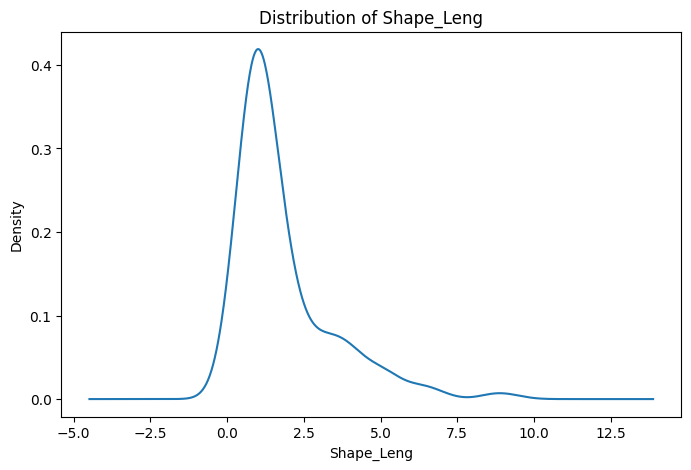

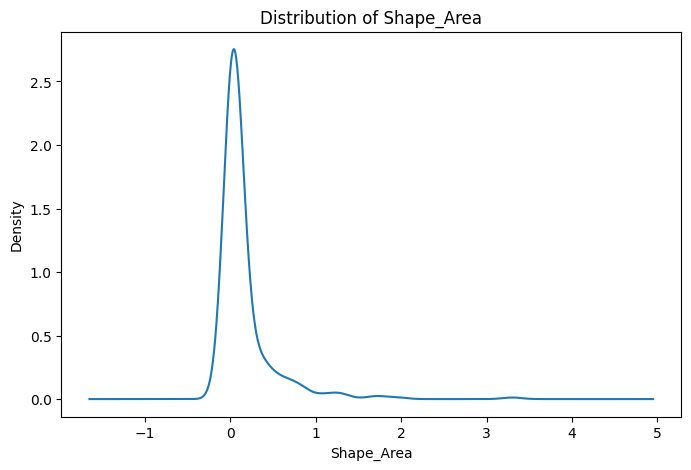

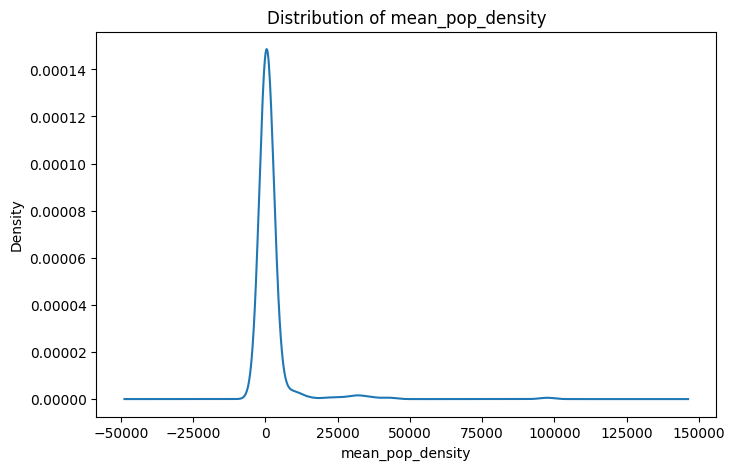

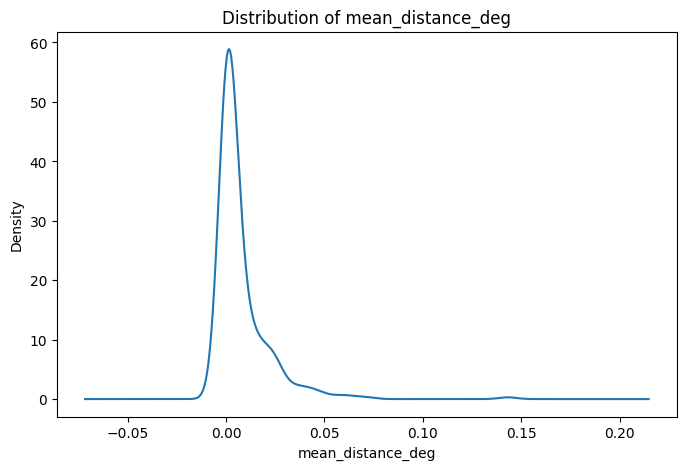

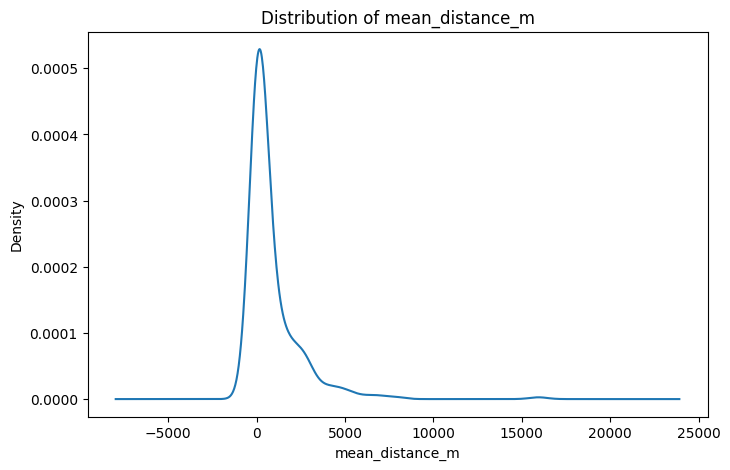

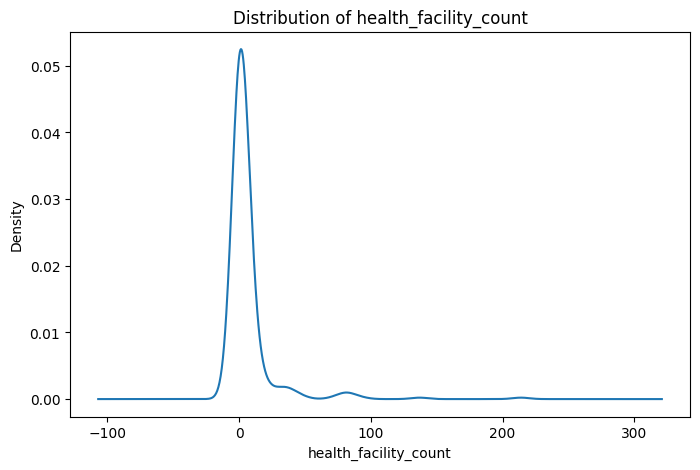

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Select numeric columns only (exclude non-numeric and geometry)
numeric_cols = [
    'Shape_Leng',
    'Shape_Area',
    'mean_pop_density',
    'mean_distance_deg',
    'mean_distance_m',
    'health_facility_count'
]

# Convert selected columns to numeric, coercing errors to NaN
for col in numeric_cols:
    enhanced_features_gdf[col] = pd.to_numeric(enhanced_features_gdf[col], errors='coerce')

# Drop rows with NaN created by coercion if necessary, or handle them
# For plotting KDE, NaN values are typically ignored.

# Plot distribution curves for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    # Using .dropna() to ensure only numeric values are passed to kde plot
    enhanced_features_gdf[col].dropna().plot(kind="kde")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

### visualizations

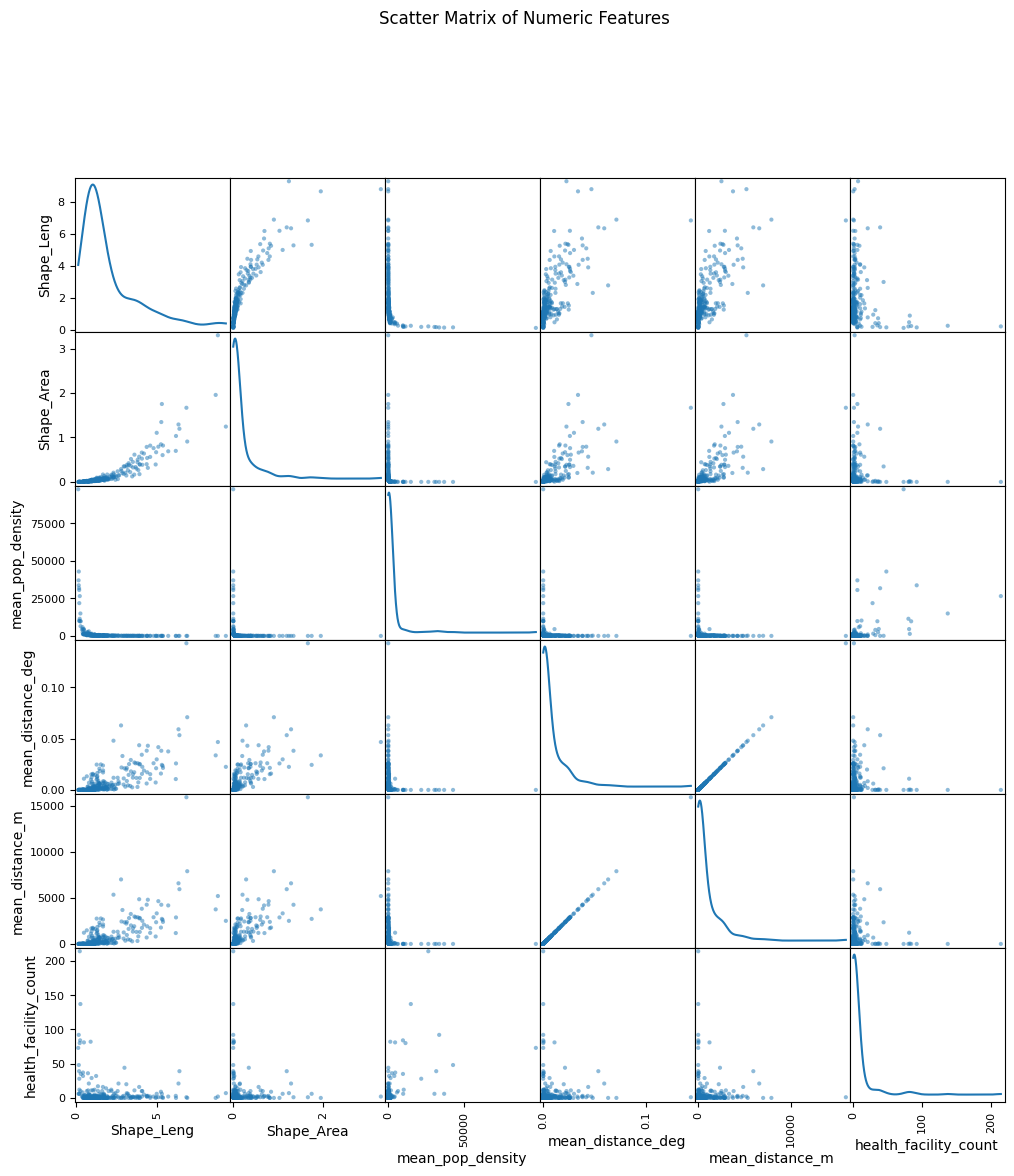

In [120]:
import pandas as pd

pd.plotting.scatter_matrix(
    enhanced_features_gdf[numeric_cols].dropna(),
    figsize=(12, 12),
    diagonal="kde",  # KDE on the diagonal instead of hist
    alpha=0.5
)
plt.suptitle("Scatter Matrix of Numeric Features", y=1.02)
plt.show()


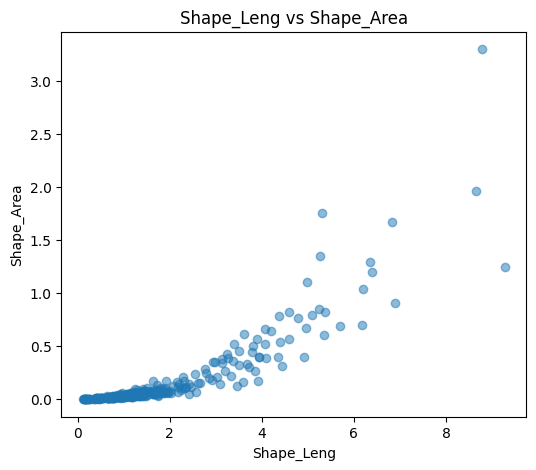

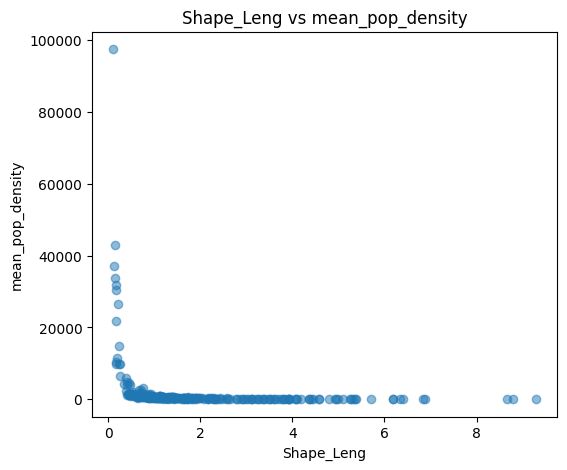

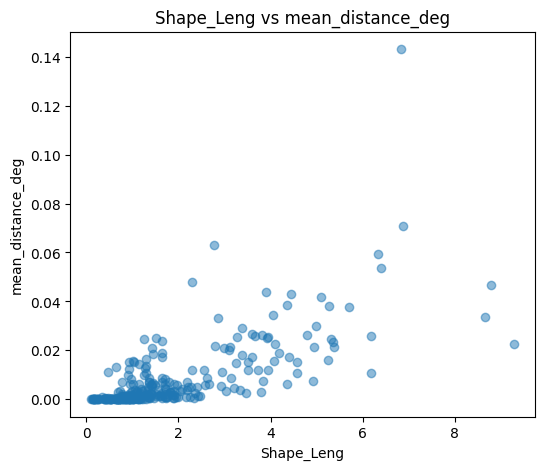

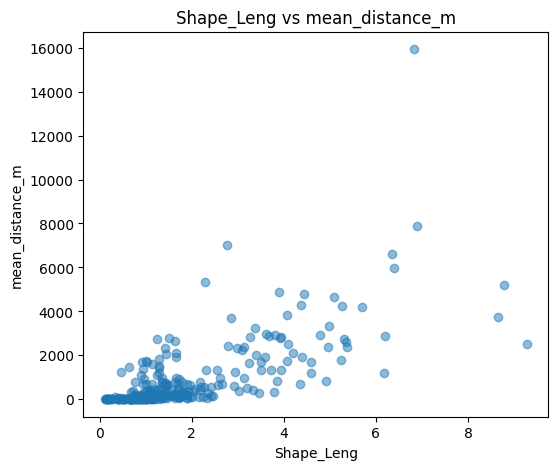

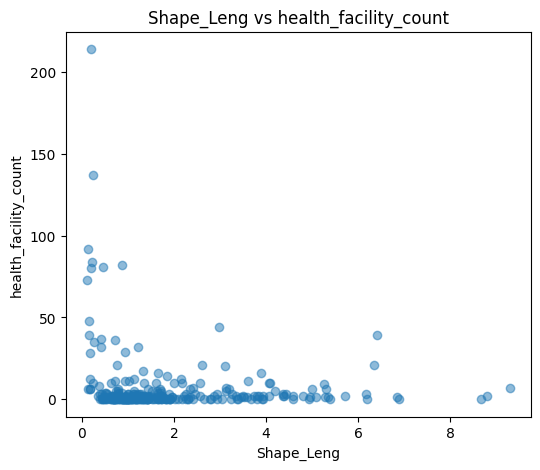

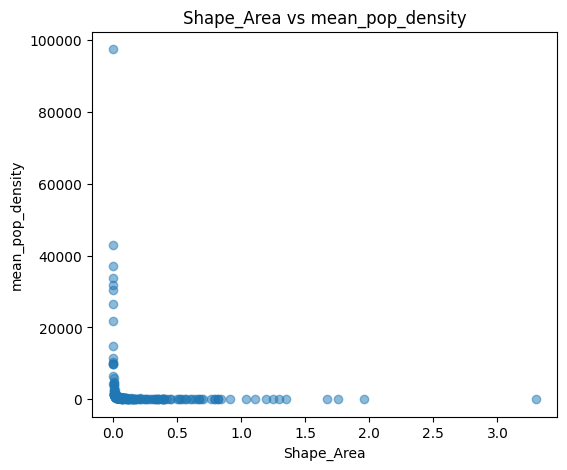

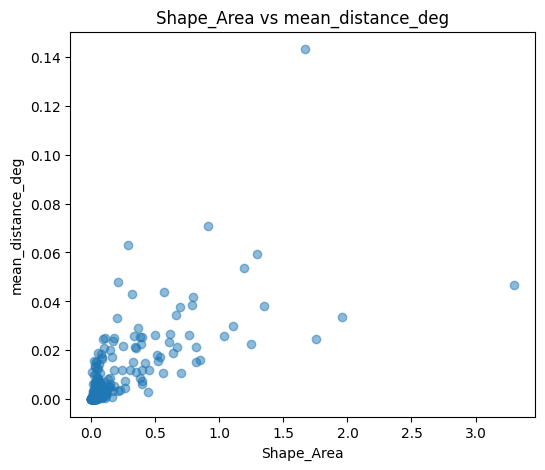

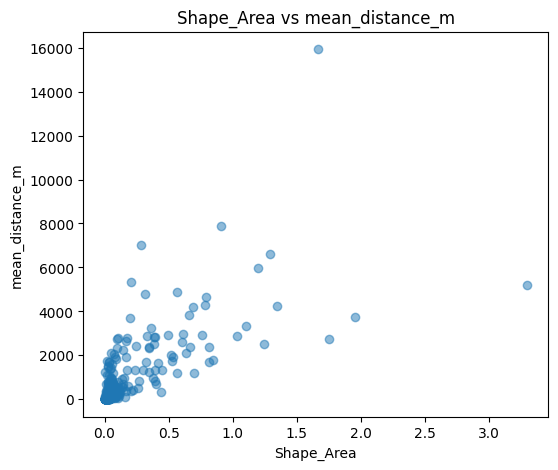

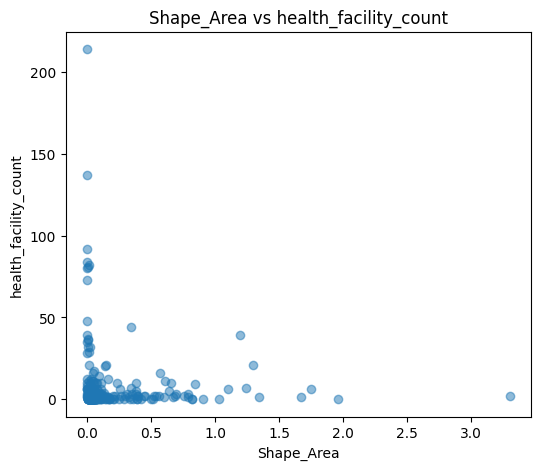

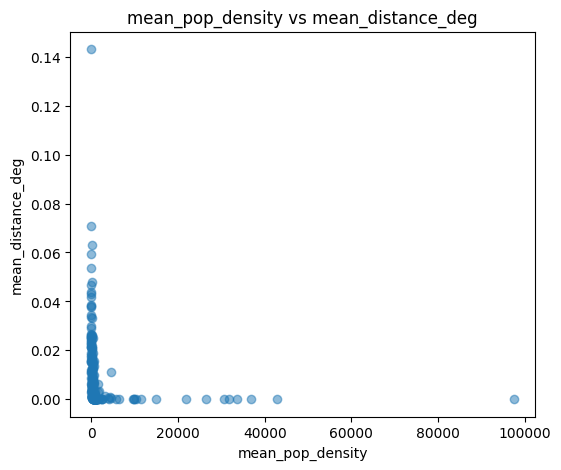

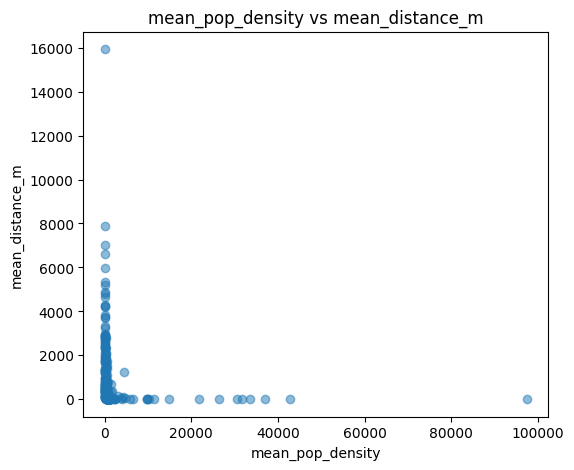

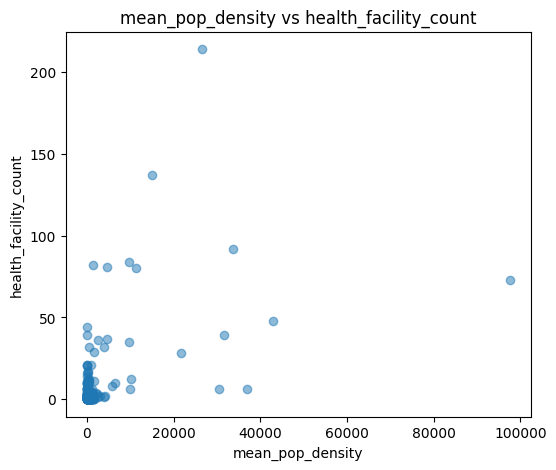

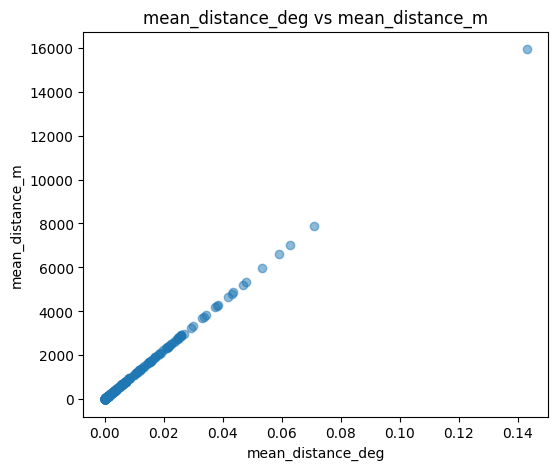

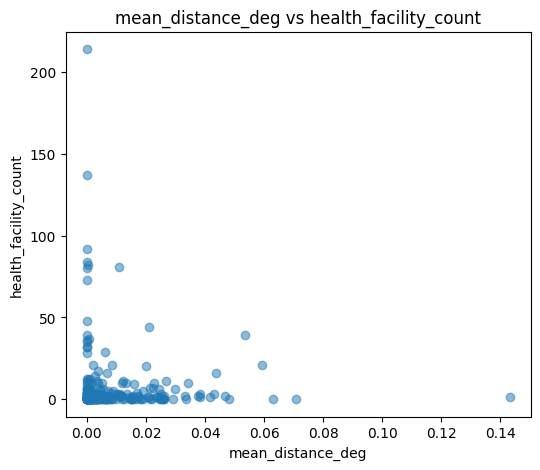

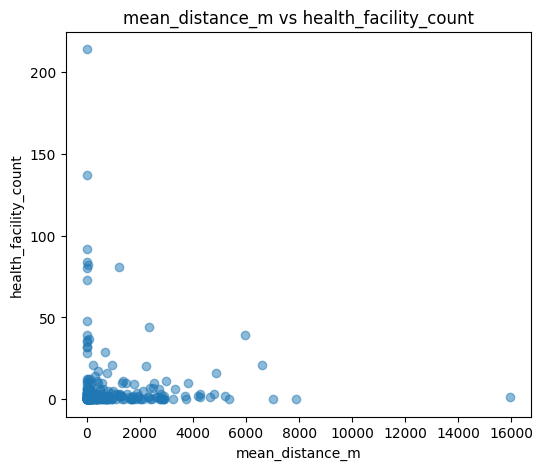

In [121]:
from itertools import combinations

df_numeric = enhanced_features_gdf[numeric_cols].dropna()

for col_x, col_y in combinations(numeric_cols, 2):
    plt.figure(figsize=(6, 5))
    plt.scatter(df_numeric[col_x], df_numeric[col_y], alpha=0.5)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f"{col_x} vs {col_y}")
    plt.show()


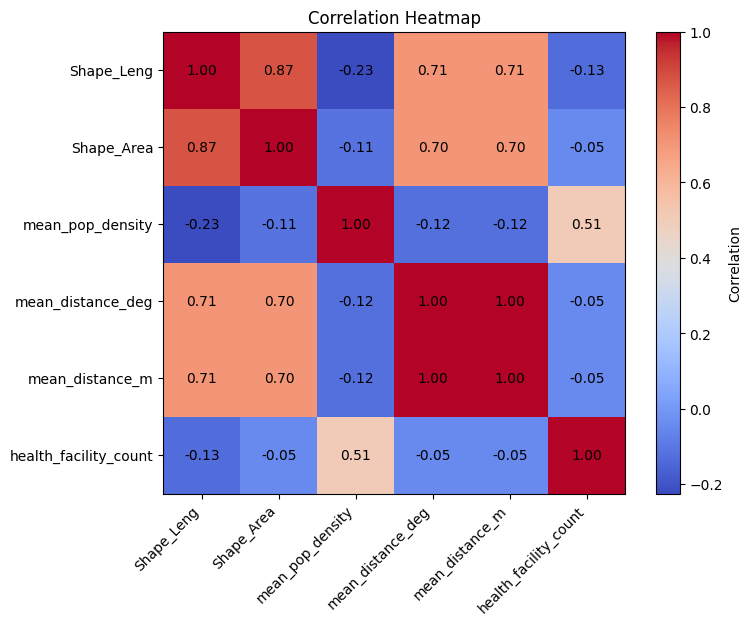

In [122]:
corr = enhanced_features_gdf[numeric_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)

# Annotate values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Correlation Heatmap")
plt.show()


In [123]:
# import geopandas as gpd
# import pandas as pd # Import pandas

# # Load the data from the CSV
# enhanced_features_gdf = pd.read_csv('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.csv')

# # Convert the DataFrame to a GeoDataFrame
# # Assuming the 'geometry' column is in WKT format and the original CRS was EPSG:4326
# # You might need to adjust the CRS based on your data source if it's different.
# enhanced_features_gdf = gpd.GeoDataFrame(
#     enhanced_features_gdf,
#     geometry=gpd.GeoSeries.from_wkt(enhanced_features_gdf['geometry']),
#     crs="EPSG:4326" # Set the CRS here
# )

# # Now, enhanced_features_gdf is a GeoDataFrame and you can use to_file
# enhanced_features_gdf.to_file('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.shp')

# print("✅ GeoDataFrame saved as shapefile.")

In [124]:
## Display all columns and their data types
enhanced_features_gdf.dtypes

Shape_Leng               float64
Shape_Area               float64
ADM2_EN                   object
ADM2_PCODE                object
ADM2_REF                  object
ADM2ALT1EN                object
ADM2ALT2EN                object
ADM1_EN                   object
ADM1_PCODE                object
ADM0_EN                   object
ADM0_PCODE                object
date                      object
validOn                   object
ValidTo                   object
geometry                  object
mean_pop_density         float64
mean_distance_deg        float64
mean_distance_m          float64
health_facility_count      int64
dtype: object

## Equity & Accessibility Insights

Facilities per population density

In [125]:
enhanced_features_gdf["facilities_per_density"] = (
    enhanced_features_gdf["health_facility_count"] / enhanced_features_gdf["mean_pop_density"]
)


**Facility density per area**

In [126]:
enhanced_features_gdf["facilities_per_area"] = (
    enhanced_features_gdf["health_facility_count"] / enhanced_features_gdf["Shape_Area"]
)


In [127]:
enhanced_features_gdf

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE ADM2_REF ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144                       
1      0.917307    0.019957         Ainamoi   KE035190                       
2      1.402637    0.038000           Aldai   KE029152                       
3      1.081354    0.049357    Alego Usonga   KE041234                       
4      0.743915    0.021365          Awendo   KE044254                       
..          ...         ...             ...        ...      ...        ...   
285    1.010876    0.019180     Webuye West   KE039222                       
286    0.630183    0.014610  West Mugirango   KE046271                       
287    0.405298    0.005908       Westlands   KE047274                       
288    1.214526    0.069243        Wundanyi   KE006024                       
289    1.737731    0.086211           Yatta   KE016076                       

    ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN  ...        date     validOn  \
0                Uasin Gishu      KE027   Kenya  ...  2017-11-03  2019-10-31   
1                    Kericho      KE035   Kenya  ...  2017-11-03  2019-10-31   
2                      Nandi      KE029   Kenya  ...  2017-11-03  2019-10-31   
3                      Siaya      KE041   Kenya  ...  2017-11-03  2019-10-31   
4                     Migori      KE044   Kenya  ...  2017-11-03  2019-10-31   
..         ...           ...        ...     ...  ...         ...         ...   
285                  Bungoma      KE039   Kenya  ...  2017-11-03  2019-10-31   
286                  Nyamira      KE046   Kenya  ...  2017-11-03  2019-10-31   
287                  Nairobi      KE047   Kenya  ...  2017-11-03  2019-10-31   
288             Taita Taveta      KE006   Kenya  ...  2017-11-03  2019-10-31   
289                 Machakos      KE016   Kenya  ...  2017-11-03  2019-10-31   

    ValidTo                                           geometry  \
0            POLYGON ((35.35932922400008 0.5210847780000449...   
1            POLYGON ((35.26262436300004 -0.230643833999977...   
2            POLYGON ((34.93988910100006 0.0821084490000317...   
3            POLYGON ((34.20727064500005 0.1597125340000502...   
4            POLYGON ((34.54576589900006 -0.748203936999971...   
..      ...                                                ...   
285          MULTIPOLYGON (((34.67979367600003 0.5845896150...   
286          POLYGON ((34.931885469000065 -0.50114522699993...   
287          POLYGON ((36.79870224000007 -1.192913293999936...   
288          POLYGON ((38.43298150600003 -3.243663910999942...   
289          POLYGON ((37.518569194000065 -1.05319414699994...   

    mean_pop_density  mean_distance_deg  mean_distance_m  \
0         309.248096           0.000742        82.653135   
1         851.060467           0.000143        15.884702   
2         492.913453           0.002069       230.285182   
3         393.381925           0.001153       128.390392   
4         533.473127           0.000391        43.555650   
..               ...                ...              ...   
285       688.114507           0.000091        10.156934   
286      1118.328198           0.000000         0.000000   
287      4006.943382           0.000000         0.000000   
288        94.923198           0.003186       354.641893   
289       174.944792           0.000724        80.573291   

     health_facility_count  facilities_per_density  facilities_per_area  
0                        2                0.006467            48.984417  
1                        1                0.001175            50.108609  
2                        0                0.000000             0.000000  
3                        0                0.000000             0.000000  
4                        0                0.000000             0.000000  
..                     ...                     ...                  ...  
285                      0                0.000000             0.000000  
2

## save the changes

In [128]:
import geopandas as gpd

# Load the GeoDataFrame from the last successful save point
# This assumes D3PKLjDjATRK successfully saved the GeoDataFrame with mean_pop_density and mean_distance_m
try:
    enhanced_features_gdf = gpd.read_file('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.shp')

    # Re-calculate or ensure the columns added in the previous steps are present
    # This is necessary in case the variable was overwritten or the previous calculations were on a DataFrame
    # You might need to adjust the column names if they were truncated when saved as a shapefile
    if 'mean_pop_density' not in enhanced_features_gdf.columns and 'mean_pop_d' in enhanced_features_gdf.columns:
        enhanced_features_gdf = enhanced_features_gdf.rename(columns={'mean_pop_d': 'mean_pop_density'})
    if 'mean_distance_m' not in enhanced_features_gdf.columns and 'mean_dis_1' in enhanced_features_gdf.columns:
         enhanced_features_gdf = enhanced_features_gdf.rename(columns={'mean_dis_1': 'mean_distance_m'})


    # Add the new columns if they are not already present
    if "facilities_per_density" not in enhanced_features_gdf.columns:
         enhanced_features_gdf["facilities_per_density"] = (
            enhanced_features_gdf["health_facility_count"] / enhanced_features_gdf["mean_pop_density"]
        )

    if "facilities_per_area" not in enhanced_features_gdf.columns:
        enhanced_features_gdf["facilities_per_area"] = (
            enhanced_features_gdf["health_facility_count"] / enhanced_features_gdf["Shape_Area"]
        )


    # Save the enhanced GeoDataFrame
    enhanced_features_gdf.to_file('/content/drive/MyDrive/Miniproject/enhanced_features_gdf.shp')

    print("✅ Enhanced GeoDataFrame saved as shapefile.")

except Exception as e:
    print(f"❌ Error saving GeoDataFrame: {e}")
    print("Please check the variable 'enhanced_features_gdf' and ensure it is a valid GeoDataFrame before saving.")

❌ Error saving GeoDataFrame: 'health_facility_count'
Please check the variable 'enhanced_features_gdf' and ensure it is a valid GeoDataFrame before saving.


In [129]:
enhanced_features_gdf

Shape_Leng  Shape_Area         ADM2_EN ADM2_PCODE  ADM2_REF  ADM2ALT1EN  \
0      1.746986    0.040829        Ainabkoi   KE027144       NaN         NaN   
1      0.917307    0.019957         Ainamoi   KE035190       NaN         NaN   
2      1.402637    0.038000           Aldai   KE029152       NaN         NaN   
3      1.081354    0.049357    Alego Usonga   KE041234       NaN         NaN   
4      0.743915    0.021365          Awendo   KE044254       NaN         NaN   
..          ...         ...             ...        ...       ...         ...   
285    1.010876    0.019180     Webuye West   KE039222       NaN         NaN   
286    0.630183    0.014610  West Mugirango   KE046271       NaN         NaN   
287    0.405298    0.005908       Westlands   KE047274       NaN         NaN   
288    1.214526    0.069243        Wundanyi   KE006024       NaN         NaN   
289    1.737731    0.086211           Yatta   KE016076       NaN         NaN   

     ADM2ALT2EN       ADM1_EN ADM1_PCODE ADM0_EN  ...        date     validOn  \
0           NaN   Uasin Gishu      KE027   Kenya  ...  2017-11-03  2019-10-31   
1           NaN       Kericho      KE035   Kenya  ...  2017-11-03  2019-10-31   
2           NaN         Nandi      KE029   Kenya  ...  2017-11-03  2019-10-31   
3           NaN         Siaya      KE041   Kenya  ...  2017-11-03  2019-10-31   
4           NaN        Migori      KE044   Kenya  ...  2017-11-03  2019-10-31   
..          ...           ...        ...     ...  ...         ...         ...   
285         NaN       Bungoma      KE039   Kenya  ...  2017-11-03  2019-10-31   
286         NaN       Nyamira      KE046   Kenya  ...  2017-11-03  2019-10-31   
287         NaN       Nairobi      KE047   Kenya  ...  2017-11-03  2019-10-31   
288         NaN  Taita Taveta      KE006   Kenya  ...  2017-11-03  2019-10-31   
289         NaN      Machakos      KE016   Kenya  ...  2017-11-03  2019-10-31   

    ValidTo  mean_pop_density  mean_dista  mean_distance_m  health_fac  \
0       NaN        309.248096    0.000742        82.653135           2   
1       NaN        851.060467    0.000143        15.884702           1   
2       NaN        492.913453    0.002069       230.285182           0   
3       NaN        393.381925    0.001153       128.390392           0   
4       NaN        533.473127    0.000391        43.555650           0   
..      ...               ...         ...              ...         ...   
285     NaN        688.114507    0.000091        10.156934           0   
286     NaN       1118.328198    0.000000         0.000000           2   
287     NaN       4006.943382    0.000000         0.000000          32   
288     NaN         94.923198    0.003186       354.641893           0   
289     NaN        174.944792    0.000724        80.573291           2   

     facilities   faciliti_1  \
0      0.006467    48.984417   
1      0.001175    50.108609   
2      0.000000     0.000000   
3      0.000000     0.000000   
4      0.000000     0.000000   
..          ...          ...   
285    0.000000     0.000000   
286    0.001788   136.895718   
287    0.007986  5416.473480   
288    0.000000     0.000000   
289    0.011432    23.198922   

                                              geometry  
0    POLYGON ((35.35933 0.52108, 35.36047 0.52079, ...  
1    POLYGON ((35.26262 -0.23064, 35.26395 -0.23135...  
2    POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3...  
3    POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3...  
4    POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ...  
..                                                 ...  
285  MULTIPOLYGON (((34.67979 0.58459, 34.67877 0.5...  
286  POLYGON ((34.93189 -0.50115, 34.93215 -0.50212...  
287  POLYGON ((36.7987 -1.19291, 36.80208 -1.1947, ...  
288  POLYGON ((38.43298 -3.24366, 38.43235 -3.25278...  
289  POLYGON ((37.51857 -1.05319, 37.5193 -1.05444,...  

[290 rows x 21 columns]

## 1. Predicting Health Facility Count

👉 How many health facilities should a constituency have?

In [130]:
columns=[x for x in enhanced_features_gdf.columns]

In [131]:
columns

['Shape_Leng',
 'Shape_Area',
 'ADM2_EN',
 'ADM2_PCODE',
 'ADM2_REF',
 'ADM2ALT1EN',
 'ADM2ALT2EN',
 'ADM1_EN',
 'ADM1_PCODE',
 'ADM0_EN',
 'ADM0_PCODE',
 'date',
 'validOn',
 'ValidTo',
 'mean_pop_density',
 'mean_dista',
 'mean_distance_m',
 'health_fac',
 'facilities',
 'faciliti_1',
 'geometry']

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Features and target
X = enhanced_features_gdf[['Shape_Area','Shape_Leng','mean_pop_density','mean_distance_m','mean_dista']]
y = enhanced_features_gdf['health_fac']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
reg_fac = RandomForestRegressor(random_state=42)
reg_fac.fit(X_train, y_train)
y_pred = reg_fac.predict(X_test)

print("Facility Count Prediction")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


Facility Count Prediction
R²: 0.20924055581410805
MAE: 5.504827586206896


## 2. Predicting Accessibility (mean_distance_m)

In [133]:
X = enhanced_features_gdf[['health_fac','facilities','Shape_Area','mean_pop_density']]
y = enhanced_features_gdf['mean_distance_m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_dist = RandomForestRegressor(random_state=42)
reg_dist.fit(X_train, y_train)
y_pred = reg_dist.predict(X_test)

print("Accessibility Prediction")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


Accessibility Prediction
R²: 0.3761860809148063
MAE: 872.8853557998334


## 3. Classification of Underserved Constituencies

👉 Binary label: well-served vs underserved.

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define underserved threshold
threshold = (enhanced_features_gdf['health_fac'] / (enhanced_features_gdf['mean_pop_density']+1e-6)).median()

enhanced_features_gdf['underserved'] = (
    (enhanced_features_gdf['health_fac'] / (enhanced_features_gdf['mean_pop_density']+1e-6)) < threshold
).astype(int)

X = enhanced_features_gdf[['Shape_Area','Shape_Leng','mean_pop_density','mean_distance_m','mean_dista']]
y = enhanced_features_gdf['underserved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Underserved Classification")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Underserved Classification
Accuracy: 0.5172413793103449
              precision    recall  f1-score   support

           0       0.49      0.67      0.56        27
           1       0.57      0.39      0.46        31

    accuracy                           0.52        58
   macro avg       0.53      0.53      0.51        58
weighted avg       0.53      0.52      0.51        58



## 4. Spatial Prediction with Neighbor Effects

👉 Neighboring constituencies influence facility counts.

In [135]:
import libpysal

# Build spatial weights (Queen contiguity)
w = libpysal.weights.Queen.from_dataframe(enhanced_features_gdf)
w.transform = 'r'

# Neighbor facility count (spatial lag)
enhanced_features_gdf['neighbor_facility_count'] = libpysal.weights.lag_spatial(
    w, enhanced_features_gdf['health_fac']
)

X = enhanced_features_gdf[['Shape_Area','Shape_Leng','mean_pop_density','mean_distance_m','neighbor_facility_count']]
y = enhanced_features_gdf['health_fac']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_spatial = RandomForestRegressor(random_state=42)
reg_spatial.fit(X_train, y_train)
y_pred = reg_spatial.predict(X_test)

print("Spatial Facility Prediction")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


Spatial Facility Prediction
R²: -0.42195564124725715
MAE: 5.54551724137931


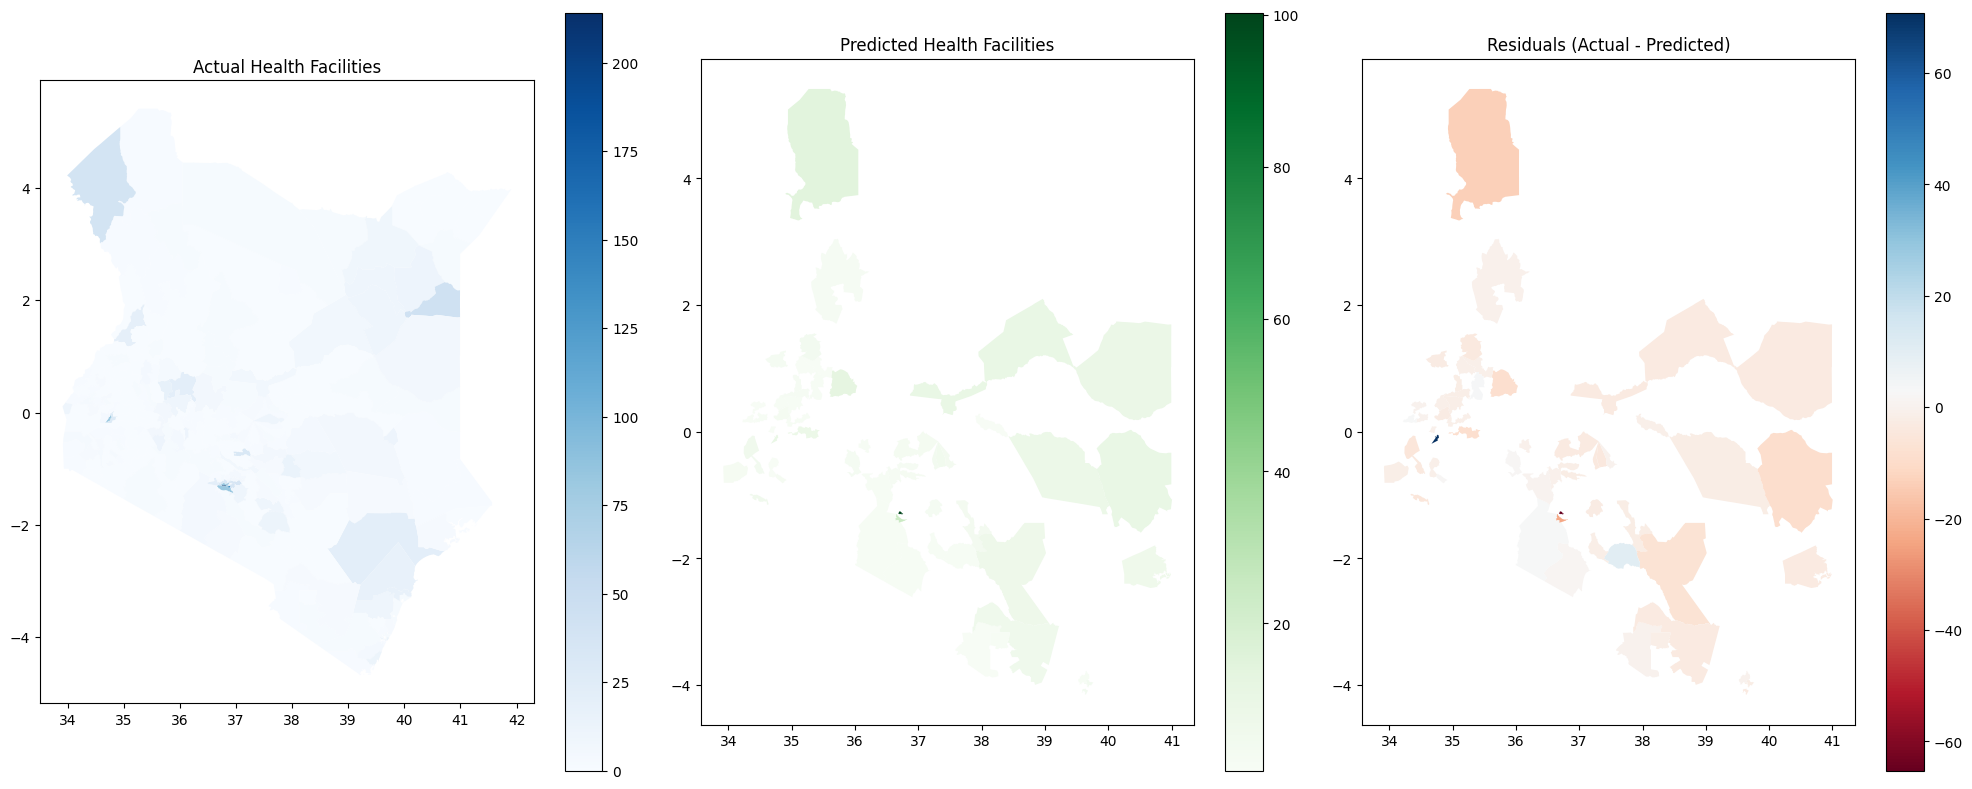

In [136]:
import matplotlib.pyplot as plt

# Add predictions back into GeoDataFrame
enhanced_features_gdf.loc[X_test.index, "predicted_facilities"] = y_pred
enhanced_features_gdf["residuals"] = enhanced_features_gdf["health_fac"] - enhanced_features_gdf["predicted_facilities"]

# Plot actual vs predicted
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Actual facilities
enhanced_features_gdf.plot(
    column="health_fac",
    cmap="Blues",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Actual Health Facilities")

# Predicted facilities
enhanced_features_gdf.plot(
    column="predicted_facilities",
    cmap="Greens",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Predicted Health Facilities")

# Residuals (error)
enhanced_features_gdf.plot(
    column="residuals",
    cmap="RdBu",
    legend=True,
    ax=axes[2]
)
axes[2].set_title("Residuals (Actual - Predicted)")

plt.tight_layout()
plt.show()
